In [18]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 18,

    # Axes
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 2,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

In [21]:
path_models = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet"
)

tpcs_eval = [10,20,25,30,50,75,100,150]

info_eval = {
    "ntopics": tpcs_eval,
    "cohrs_mean": [],
    #"cohrs_var" : [],
    "disp_perc_mean": [],
    #"disp_perc_var": []
}

dfs_results = []
for model_ in ["all", "outsiders", "insiders", "minors"]:
    info_eval = {
        "ntopics": tpcs_eval,
        "cohrs_mean": [],
        #"cohrs_var" : [],
        "disp_perc_mean": [],
        #"disp_perc_var": []
    }
    
    for tpc in tpcs_eval:
        path_model = path_models / f"es_Mallet_{model_}_{tpc}_topics" / "model_data" / "TMmodel"

        cohrs = np.load(path_model.joinpath('topic_coherence.npy'))
        if any(np.isnan(cohrs)):
            with (path_model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
                tpc_descriptions =  [el.strip() for el in fin.readlines()]

            corpusFile =  path_models / f"es_Mallet_all_{tpc}_topics" / 'train_data/corpus.txt'
            with corpusFile.open("r", encoding="utf-8") as f:
                lines = f.readlines()  # Read all lines into a list
                f.seek(0)  # Reset the file pointer to the beginning
                try:
                    corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]
                except:
                    corpus = [line.rsplit("\t0\t")[1].strip().split() for line in lines]
            dictionary = Dictionary(corpus)
            cm = CoherenceModel(topics=tpc_descriptions,texts=corpus, dictionary=dictionary,coherence="c_v", topn=15)
            cohrs = cm.get_coherence_per_topic()
        info_eval["cohrs_mean"].append(np.mean(cohrs))
        #info_eval["cohrs_var"].append(np.std(topic_coherence))
        thetas = sparse.load_npz(path_model.joinpath('thetas.npz'))
        disp_perc = 100 * ((thetas.shape[0] * thetas.shape[1]) - len(thetas.data)) / (thetas.shape[0] * thetas.shape[1])
        info_eval["disp_perc_mean"].append(np.mean(disp_perc))
        #info_eval["disp_perc_var"].append(np.std(disp_perc))

    info_eval_df = pd.DataFrame(info_eval)
    print(info_eval_df)
    dfs_results.append(info_eval_df)

   ntopics  cohrs_mean  disp_perc_mean
0       10    0.619818       65.160896
1       20    0.621279       85.689743
2       25    0.630150       88.335124
3       30    0.653233       93.839328
4       50    0.626041       96.210294
5       75    0.625739       98.148998
6      100    0.637099       98.614650
7      150    0.634339       99.045030
   ntopics  cohrs_mean  disp_perc_mean
0       10    0.584487       88.787349
1       20    0.614333       94.346317
2       25    0.597375       95.421822
3       30    0.597878       96.147194
4       50    0.622409       97.694593
5       75    0.617849       98.417873
6      100    0.615502       98.758326
7      150    0.612867       99.173320
   ntopics  cohrs_mean  disp_perc_mean
0       10    0.685824       59.091738
1       20    0.636473       87.256489
2       25    0.631435       91.300005
3       30    0.629188       94.070659
4       50    0.616931       97.273541
5       75    0.636093       97.649778
6      100    0.620521   

MODELS: all
MODELS: outsiders
MODELS: insiders
MODELS: minors


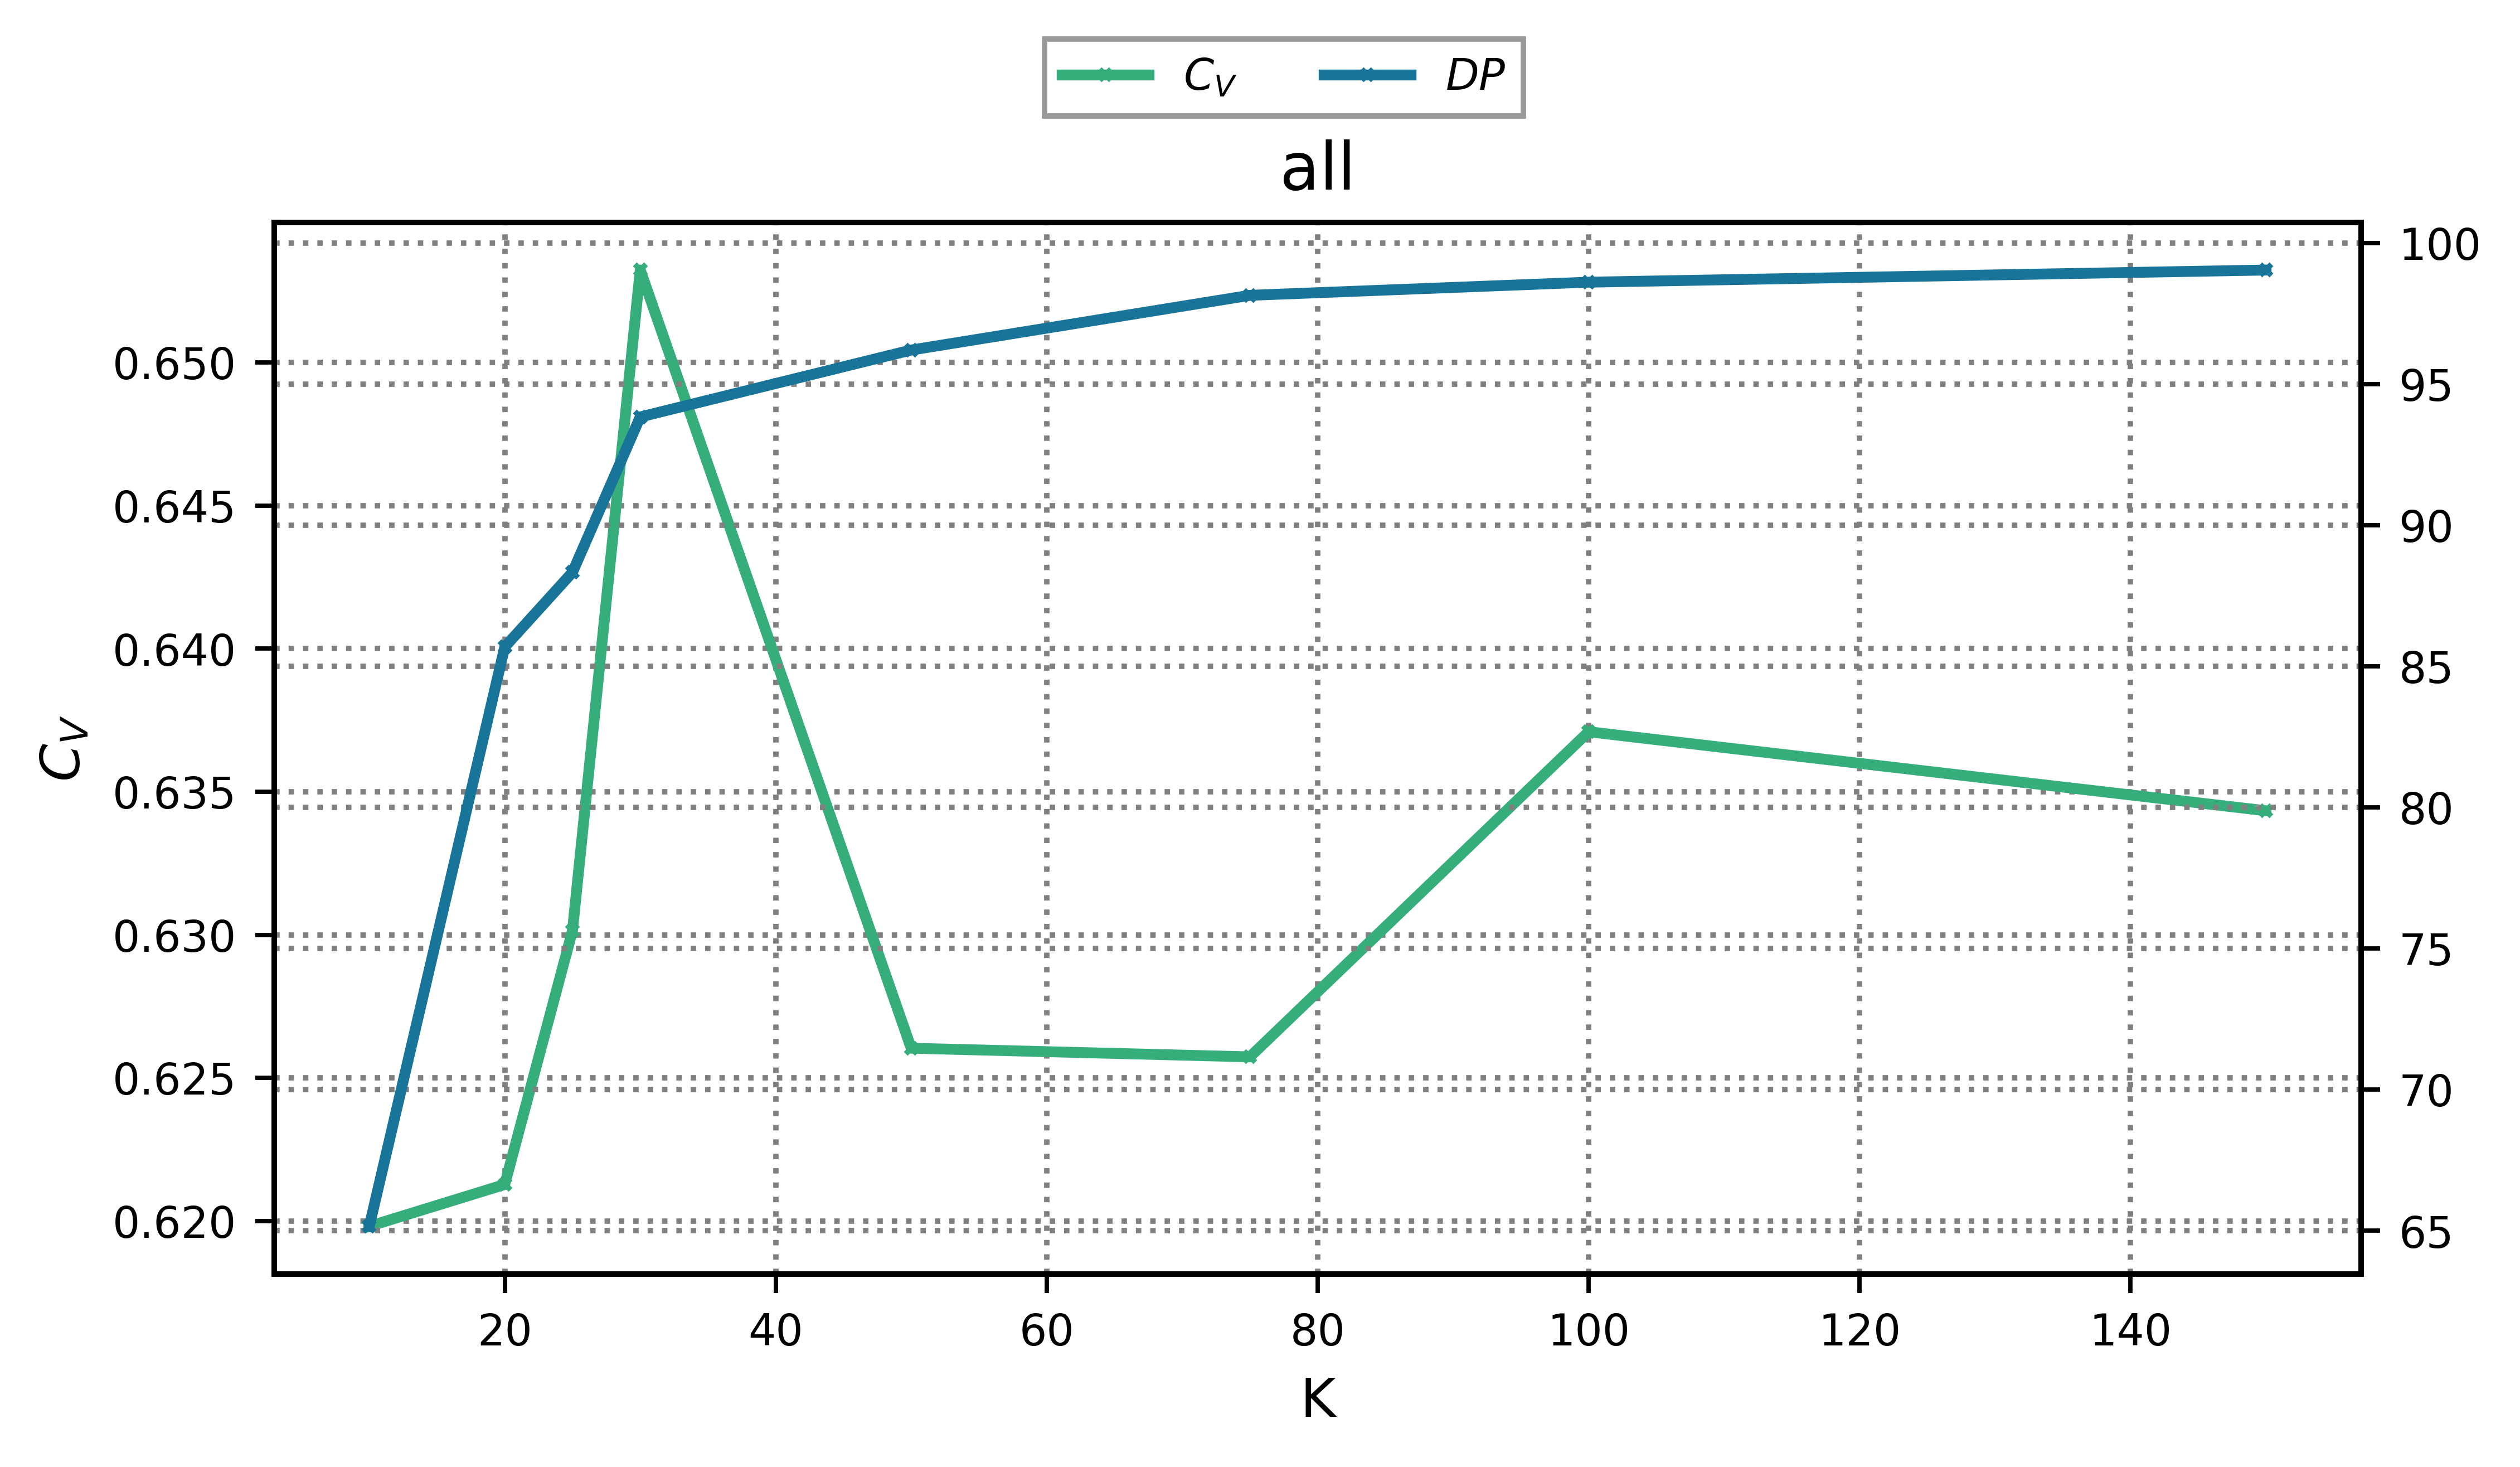

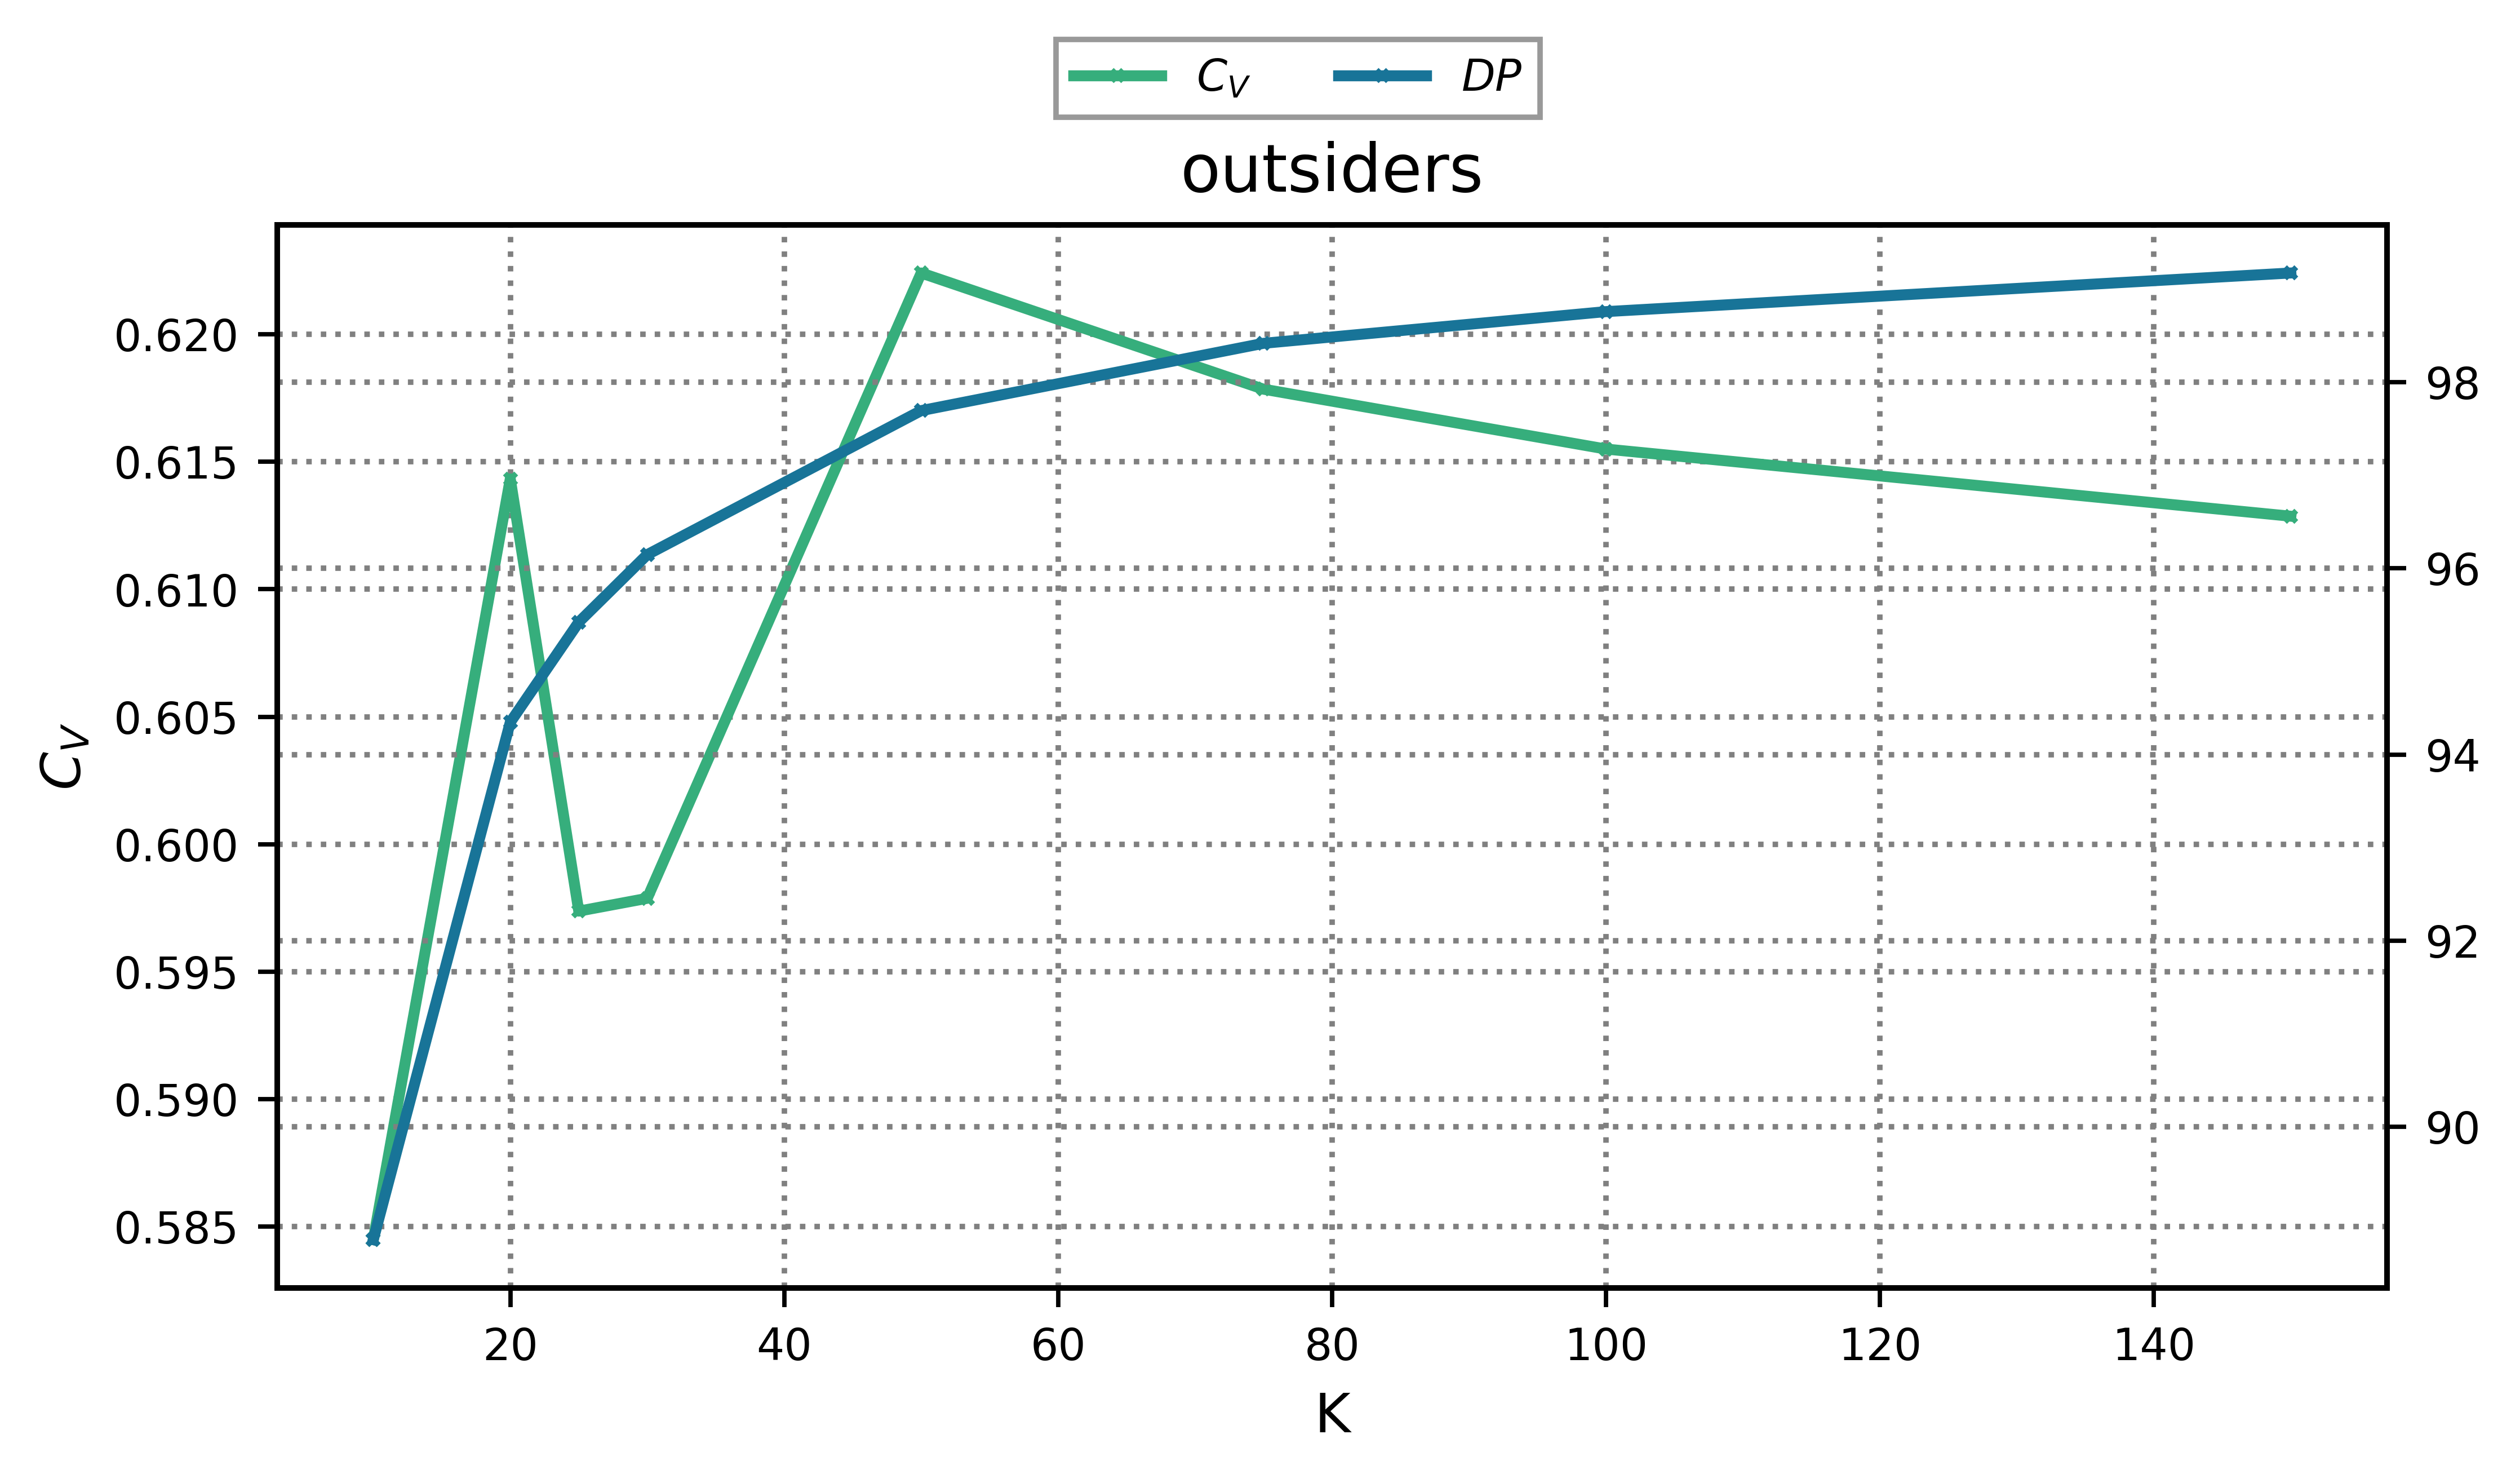

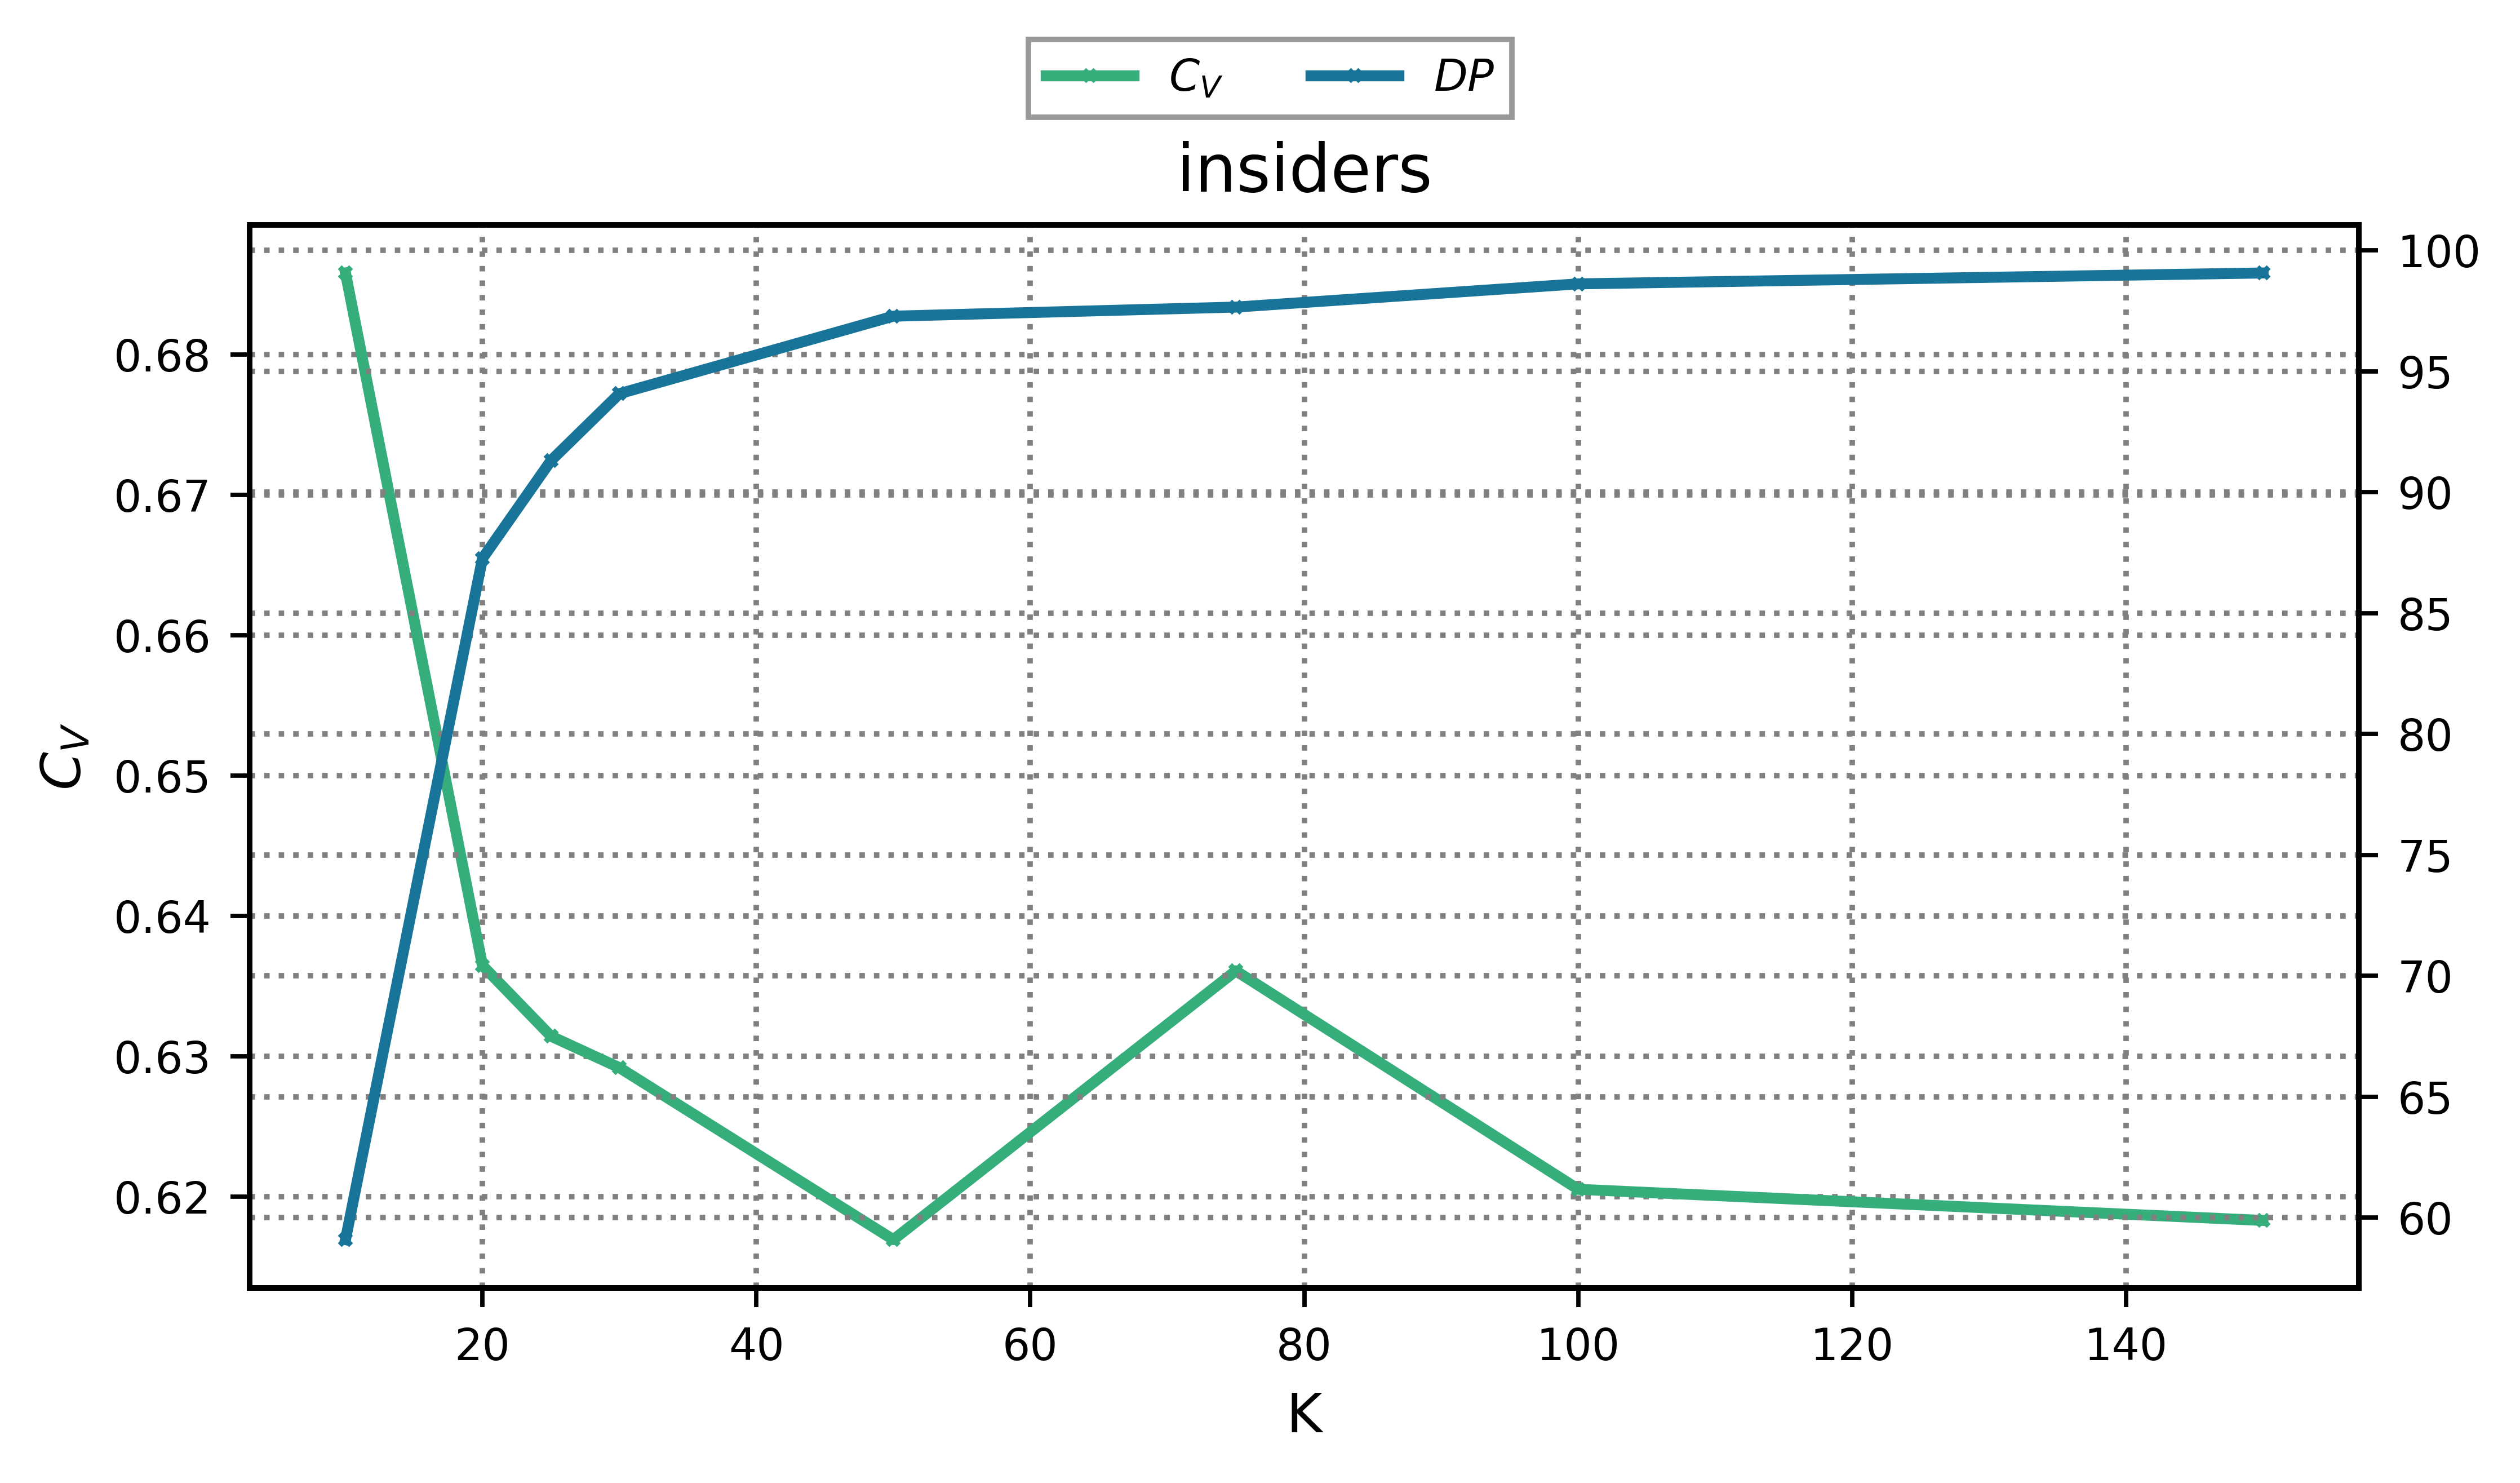

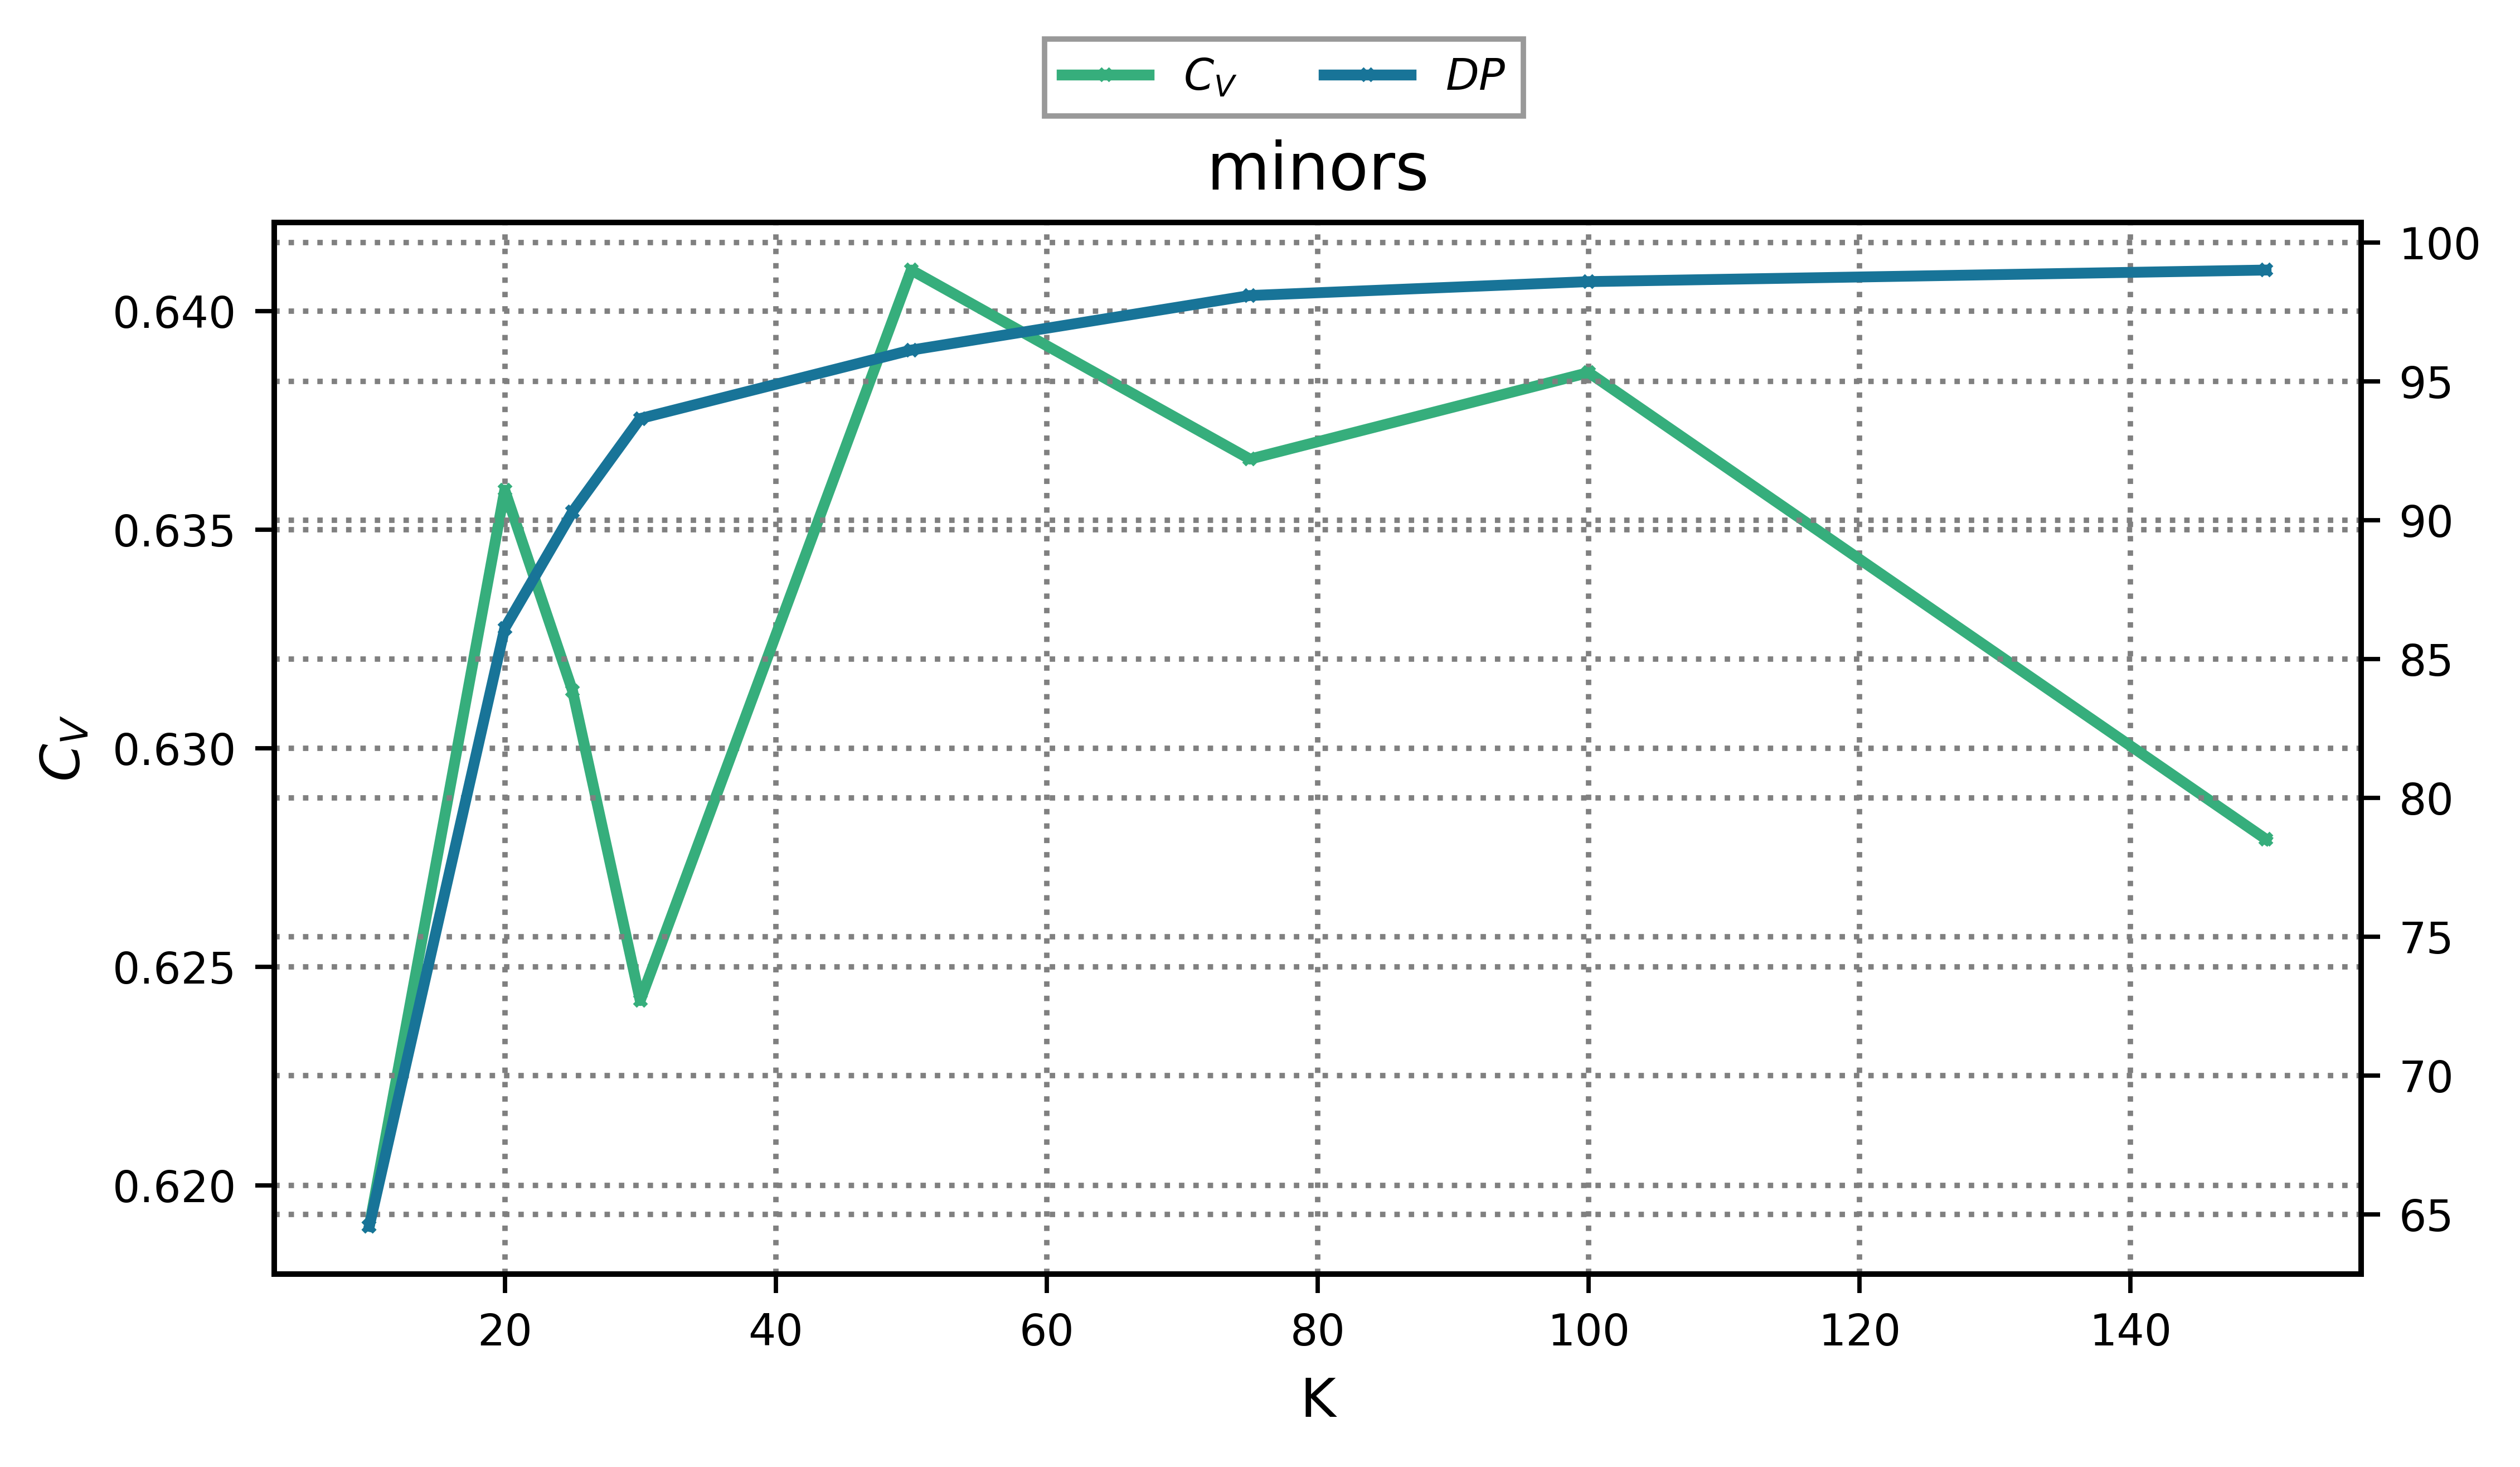

In [25]:
models_names = ["all", "outsiders", "insiders", "minors"]
for info_eval_df, name in zip(dfs_results,models_names):
    
    print(f"MODELS: {name}")
    
    fig, axs = plt.subplots(nrows=1, ncols=1)

    axs.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['cohrs_mean'],
        #yerr=info_eval_df['cohrs_var'],
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#36AE7C',
        label='$C_{V}$')

    ax2 = axs.twinx()
    ax2.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['disp_perc_mean'],
        #yerr=info_eval_df['disp_perc_var'], 
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#187498',
        label='$DP$')

    axs.grid(True)
    axs.set_xlabel('K')
    axs.set_ylabel('$C_{V}$')
    axs.set_title(name)
    ax2.grid(True)

    handles_all, labels_all = axs.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03),
               frameon=True, shadow=False)

   ntopics  cohrs_mean  disp_perc_mean
0       30    0.674288       93.177700
1       35    0.676821       95.884196
2       40    0.666977       96.535139
3       50    0.654259       97.143408
4       55    0.680397       97.507574
5       60    0.662311       97.786224
6       65    0.657396       97.904060
7       70    0.672404       98.039408
8       75    0.659337       98.188685
9       80    0.648545       98.237959
MODELS: all


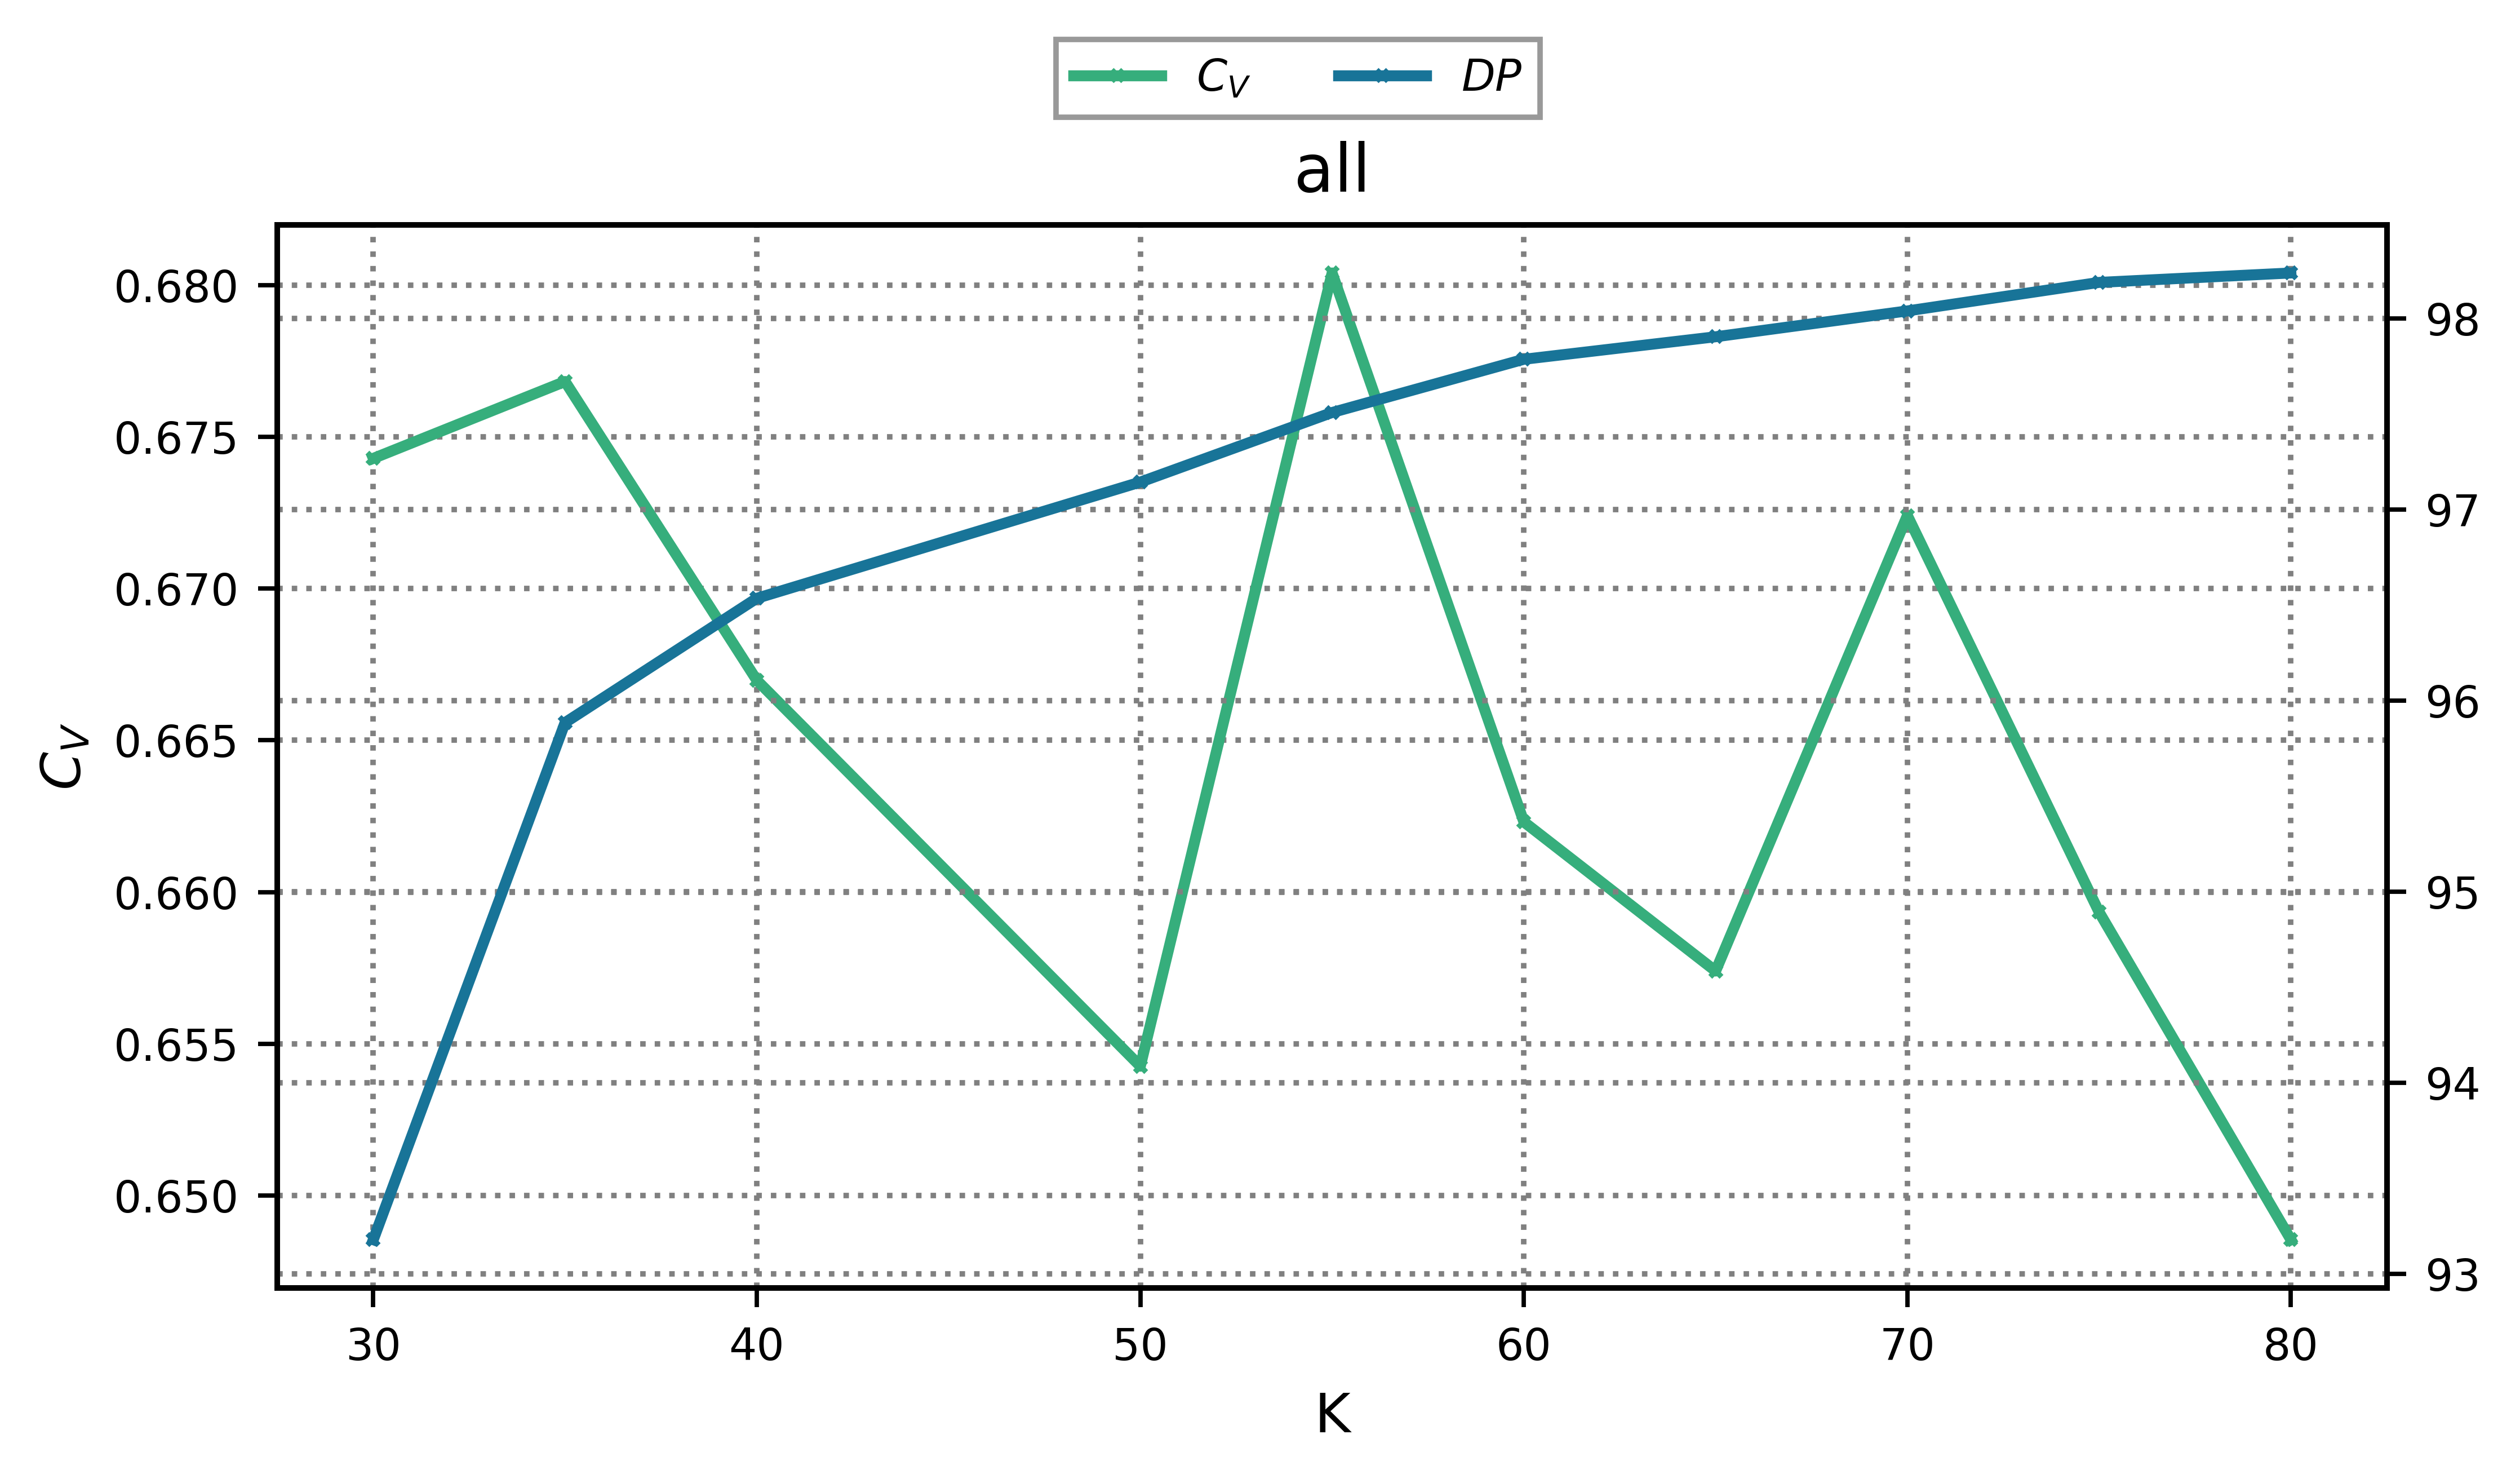

In [32]:
path_models = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet"
)

tpcs_eval = [30,35,40,50,55,60,65,70,75,80]

info_eval = {
    "ntopics": tpcs_eval,
    "cohrs_mean": [],
    #"cohrs_var" : [],
    "disp_perc_mean": [],
    #"disp_perc_var": []
}

dfs_results = []
for model_ in ["all"]:
    info_eval = {
        "ntopics": tpcs_eval,
        "cohrs_mean": [],
        #"cohrs_var" : [],
        "disp_perc_mean": [],
        #"disp_perc_var": []
    }
    
    for tpc in tpcs_eval:
        path_model = path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / "model_data" / "TMmodel"

        cohrs = np.load(path_model.joinpath('topic_coherence.npy'))
        if any(np.isnan(cohrs)):
            with (path_model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
                tpc_descriptions =  [el.strip() for el in fin.readlines()]

            corpusFile =  path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / 'train_data/corpus.txt'
            with corpusFile.open("r", encoding="utf-8") as f:
                lines = f.readlines()  # Read all lines into a list
                f.seek(0)  # Reset the file pointer to the beginning
                try:
                    corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]
                except:
                    corpus = [line.rsplit("\t0\t")[1].strip().split() for line in lines]
            dictionary = Dictionary(corpus)
            cm = CoherenceModel(topics=tpc_descriptions,texts=corpus, dictionary=dictionary,coherence="c_v", topn=15)
            cohrs = cm.get_coherence_per_topic()
        info_eval["cohrs_mean"].append(np.mean(cohrs))
        #info_eval["cohrs_var"].append(np.std(topic_coherence))
        thetas = sparse.load_npz(path_model.joinpath('thetas.npz'))
        disp_perc = 100 * ((thetas.shape[0] * thetas.shape[1]) - len(thetas.data)) / (thetas.shape[0] * thetas.shape[1])
        info_eval["disp_perc_mean"].append(np.mean(disp_perc))
        #info_eval["disp_perc_var"].append(np.std(disp_perc))

    info_eval_df = pd.DataFrame(info_eval)
    print(info_eval_df)
    dfs_results.append(info_eval_df)
    
models_names = ["all", "outsiders", "insiders", "minors"]
for info_eval_df, name in zip(dfs_results,models_names):
    
    print(f"MODELS: {name}")
    
    fig, axs = plt.subplots(nrows=1, ncols=1)

    axs.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['cohrs_mean'],
        #yerr=info_eval_df['cohrs_var'],
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#36AE7C',
        label='$C_{V}$')

    ax2 = axs.twinx()
    ax2.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['disp_perc_mean'],
        #yerr=info_eval_df['disp_perc_var'], 
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#187498',
        label='$DP$')

    axs.grid(True)
    axs.set_xlabel('K')
    axs.set_ylabel('$C_{V}$')
    axs.set_title(name)
    ax2.grid(True)

    handles_all, labels_all = axs.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03),
               frameon=True, shadow=False)

   ntopics  cohrs_mean  disp_perc_mean
0       20    0.452832       94.353087
1       25    0.444163       95.552169
2       30    0.471279       96.256629
3       35    0.439953       96.690673
4       40    0.467633       97.136579
5       45    0.459462       97.383604
6       50    0.473738       97.674183
MODELS: all


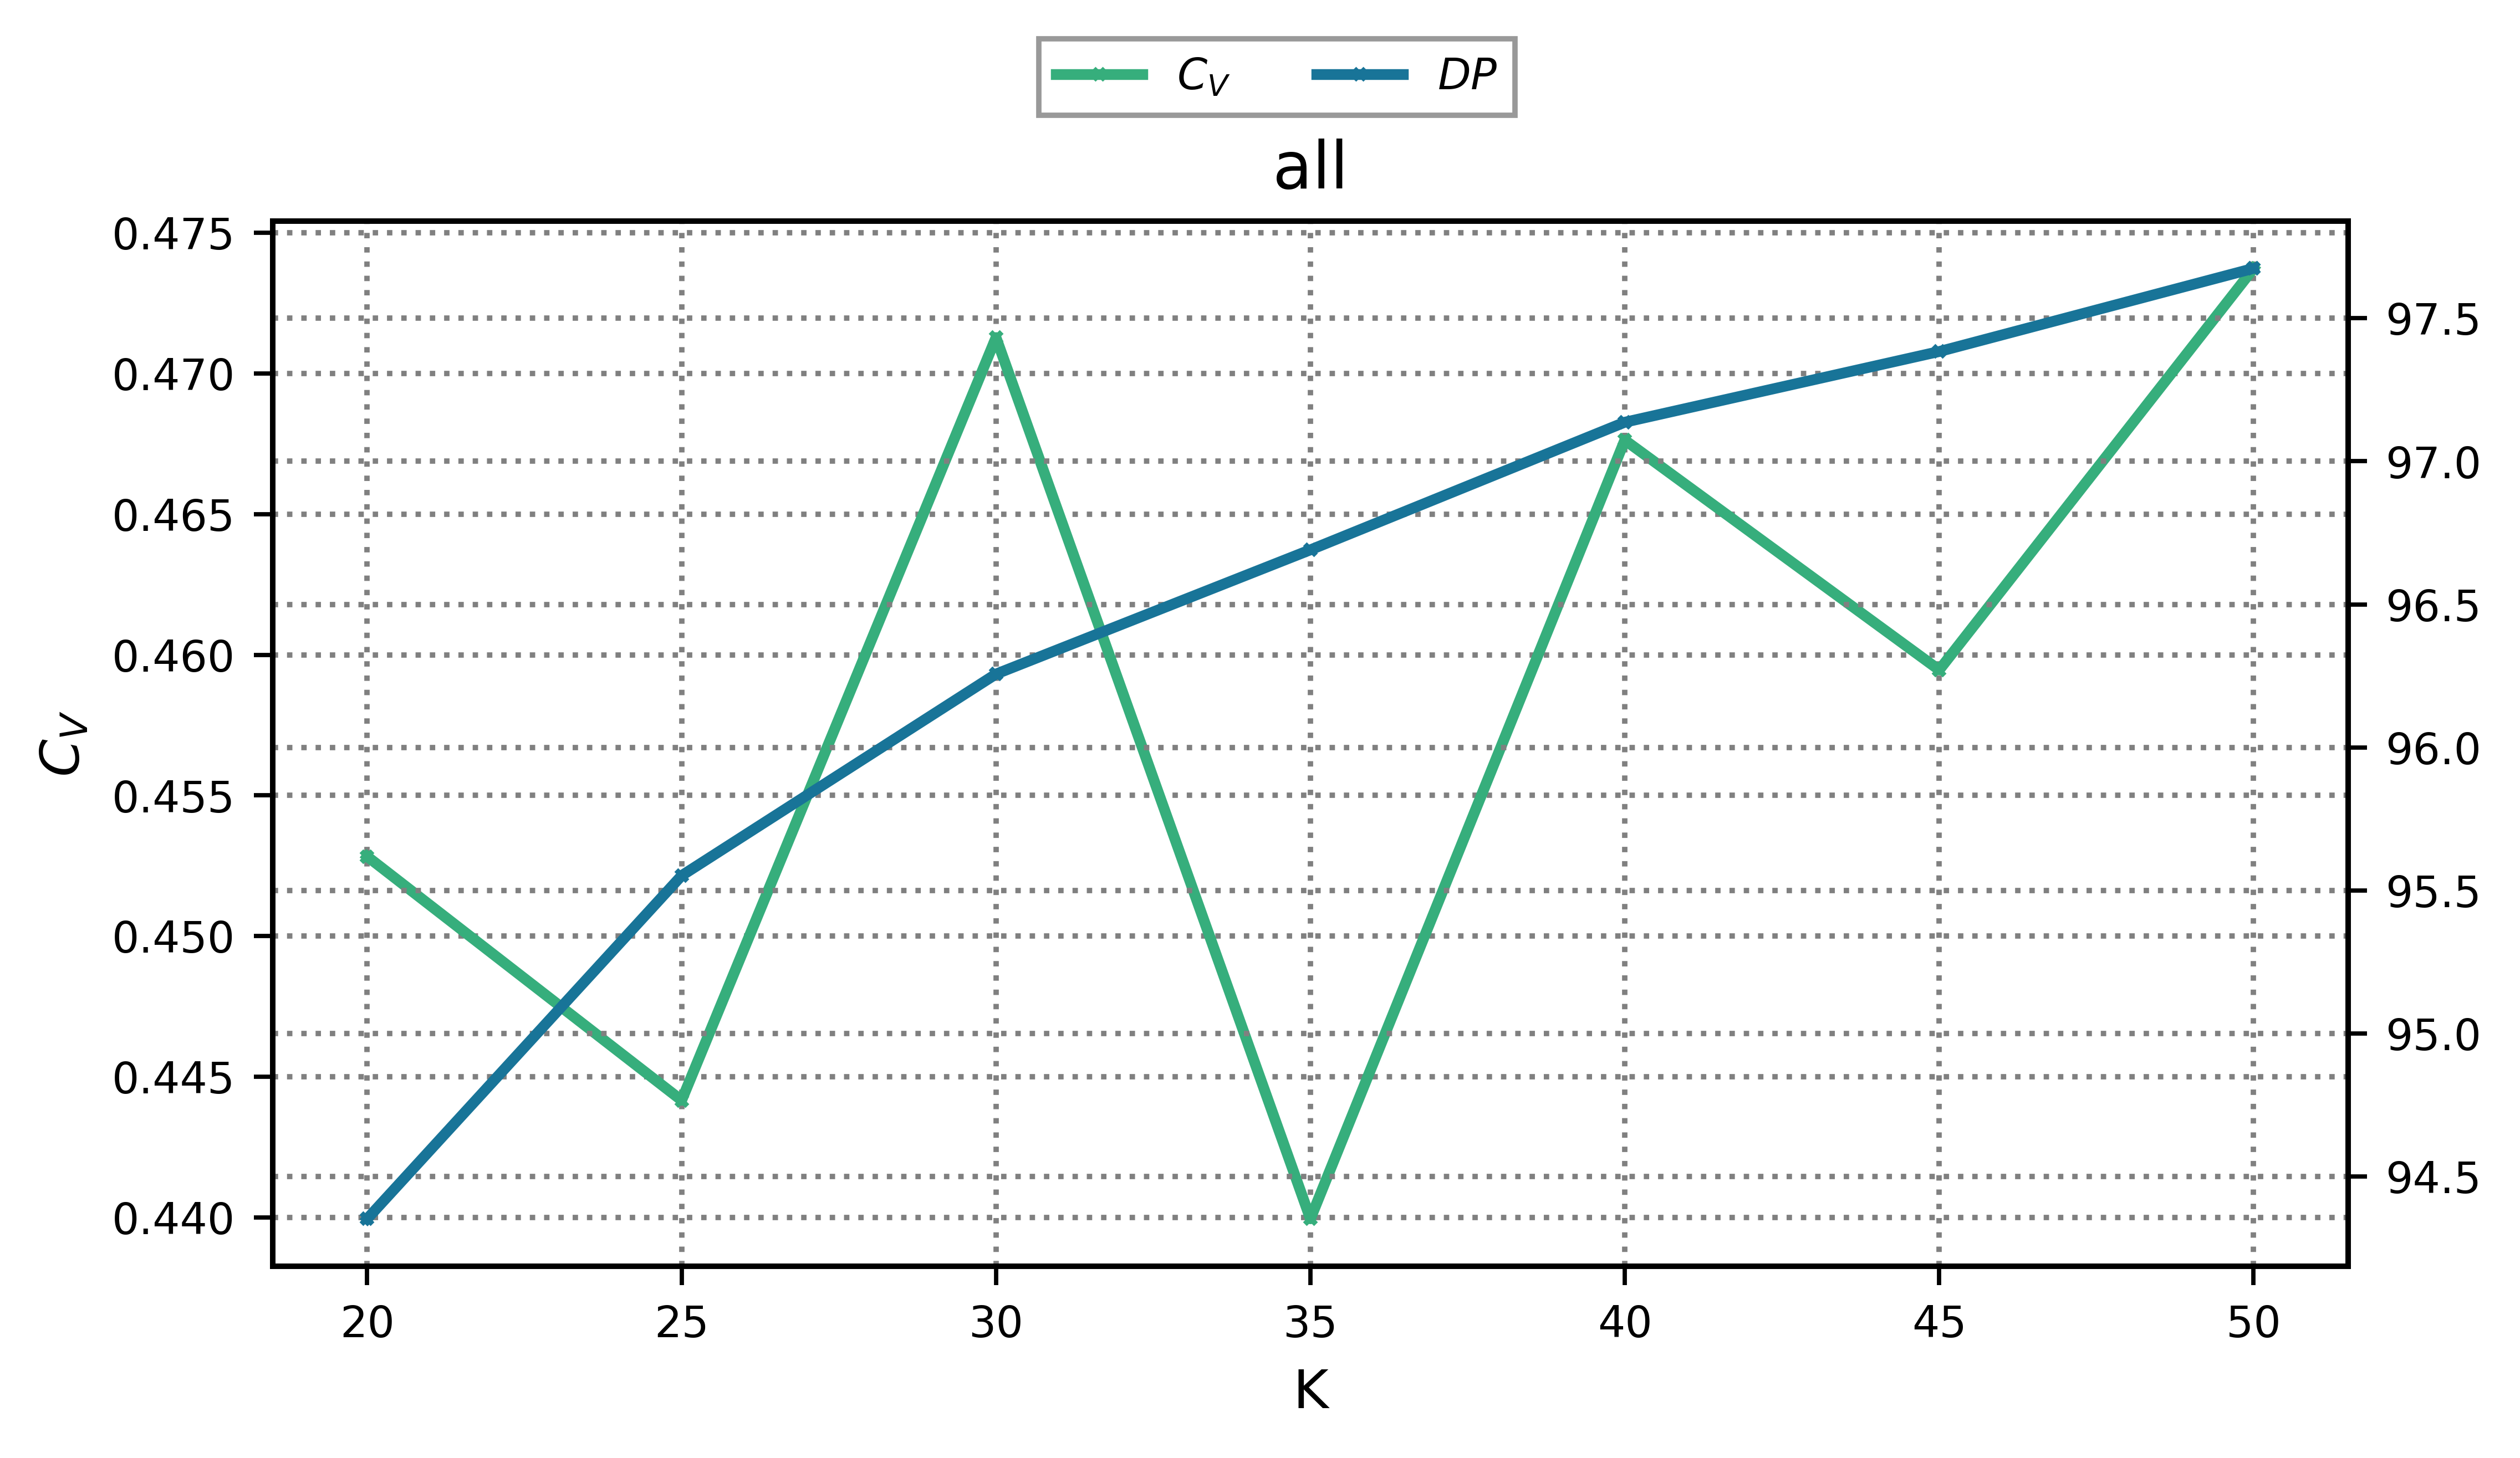

In [45]:
path_models = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet"
)

#tpcs_eval = [30,35,40,50]
tpcs_eval = [20,25,30,35,40,45,50]

info_eval = {
    "ntopics": tpcs_eval,
    "cohrs_mean": [],
    #"cohrs_var" : [],
    "disp_perc_mean": [],
    #"disp_perc_var": []
}

dfs_results = []
for model_ in ["outsiders"]:
    info_eval = {
        "ntopics": tpcs_eval,
        "cohrs_mean": [],
        #"cohrs_var" : [],
        "disp_perc_mean": [],
        #"disp_perc_var": []
    }
    
    for tpc in tpcs_eval:
        path_model = path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / "model_data" / "TMmodel"

        cohrs = np.load(path_model.joinpath('topic_coherence.npy'))
        if any(np.isnan(cohrs)):
            with (path_model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
                tpc_descriptions =  [el.strip() for el in fin.readlines()]

            corpusFile =  path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / 'train_data/corpus.txt'
            with corpusFile.open("r", encoding="utf-8") as f:
                lines = f.readlines()  # Read all lines into a list
                f.seek(0)  # Reset the file pointer to the beginning
                try:
                    corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]
                except:
                    corpus = [line.rsplit("\t0\t")[1].strip().split() for line in lines]
            dictionary = Dictionary(corpus)
            cm = CoherenceModel(topics=tpc_descriptions,texts=corpus, dictionary=dictionary,coherence="c_v", topn=15)
            cohrs = cm.get_coherence_per_topic()
        info_eval["cohrs_mean"].append(np.mean(cohrs))
        #info_eval["cohrs_var"].append(np.std(topic_coherence))
        thetas = sparse.load_npz(path_model.joinpath('thetas.npz'))
        disp_perc = 100 * ((thetas.shape[0] * thetas.shape[1]) - len(thetas.data)) / (thetas.shape[0] * thetas.shape[1])
        info_eval["disp_perc_mean"].append(np.mean(disp_perc))
        #info_eval["disp_perc_var"].append(np.std(disp_perc))

    info_eval_df = pd.DataFrame(info_eval)
    print(info_eval_df)
    dfs_results.append(info_eval_df)

models_names = ["outsiders"]
for info_eval_df, name in zip(dfs_results,models_names):
    
    print(f"MODELS: {name}")
    
    fig, axs = plt.subplots(nrows=1, ncols=1)

    axs.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['cohrs_mean'],
        #yerr=info_eval_df['cohrs_var'],
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#36AE7C',
        label='$C_{V}$')

    ax2 = axs.twinx()
    ax2.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['disp_perc_mean'],
        #yerr=info_eval_df['disp_perc_var'], 
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#187498',
        label='$DP$')

    axs.grid(True)
    axs.set_xlabel('K')
    axs.set_ylabel('$C_{V}$')
    axs.set_title(name)
    ax2.grid(True)

    handles_all, labels_all = axs.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03),
               frameon=True, shadow=False)

   ntopics  cohrs_mean  disp_perc_mean
0        5    0.620431       27.585823
1       10    0.643632       69.035002
2       11    0.608665       73.684725
3       12    0.639771       74.818922
4       13    0.595907       76.411834
5       14    0.655211       76.504184
6       15    0.604957       81.910296
7       20    0.626496       89.211738
8       30    0.591348       93.646943
9       40    0.622355       95.655514
MODELS: insiders


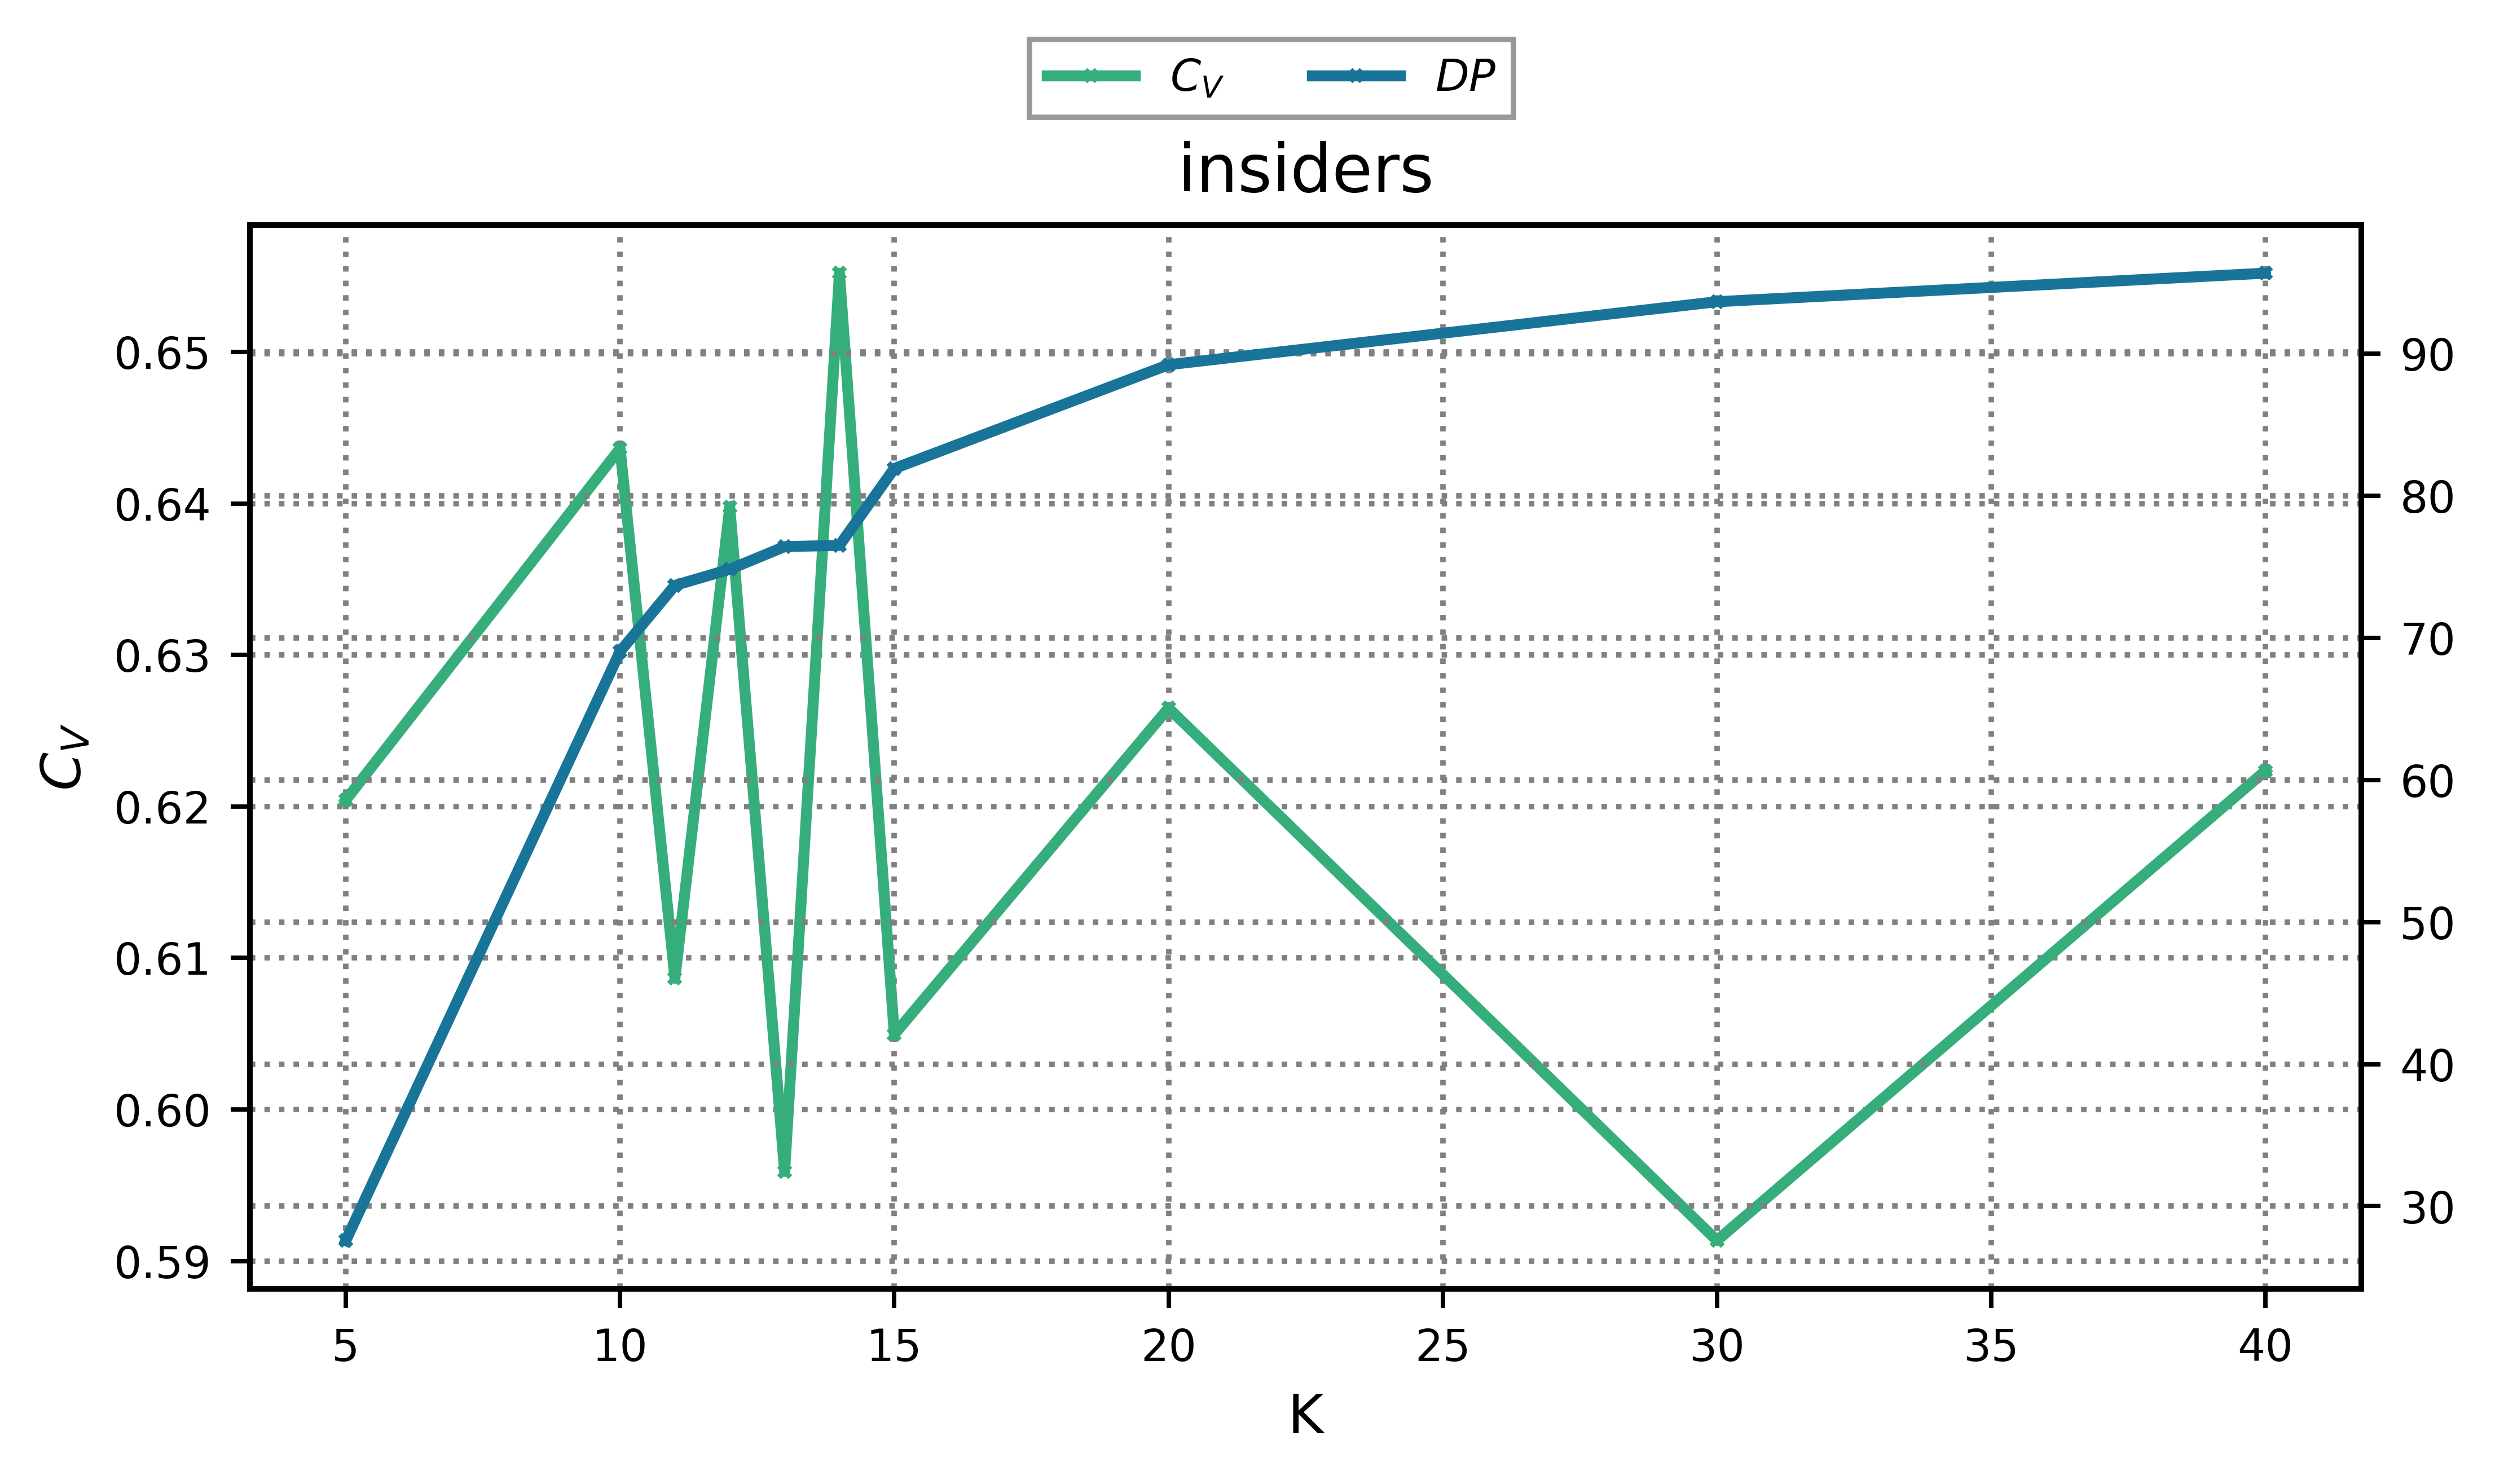

In [83]:
path_models = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet"
)

#tpcs_eval = [30,35,40,50]
tpcs_eval = [5,10,11,12,13,14,15,20,30,40]

info_eval = {
    "ntopics": tpcs_eval,
    "cohrs_mean": [],
    #"cohrs_var" : [],
    "disp_perc_mean": [],
    #"disp_perc_var": []
}

dfs_results = []
for model_ in ["insiders"]:
    info_eval = {
        "ntopics": tpcs_eval,
        "cohrs_mean": [],
        #"cohrs_var" : [],
        "disp_perc_mean": [],
        #"disp_perc_var": []
    }
    
    for tpc in tpcs_eval:
        path_model = path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / "model_data" / "TMmodel"

        cohrs = np.load(path_model.joinpath('topic_coherence.npy'))
        if any(np.isnan(cohrs)):
            with (path_model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
                tpc_descriptions =  [el.strip() for el in fin.readlines()]

            corpusFile =  path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / 'train_data/corpus.txt'
            with corpusFile.open("r", encoding="utf-8") as f:
                lines = f.readlines()  # Read all lines into a list
                f.seek(0)  # Reset the file pointer to the beginning
                try:
                    corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]
                except:
                    corpus = [line.rsplit("\t0\t")[1].strip().split() for line in lines]
            dictionary = Dictionary(corpus)
            cm = CoherenceModel(topics=tpc_descriptions,texts=corpus, dictionary=dictionary,coherence="c_v", topn=15)
            cohrs = cm.get_coherence_per_topic()
        info_eval["cohrs_mean"].append(np.mean(cohrs))
        #info_eval["cohrs_var"].append(np.std(topic_coherence))
        thetas = sparse.load_npz(path_model.joinpath('thetas.npz'))
        disp_perc = 100 * ((thetas.shape[0] * thetas.shape[1]) - len(thetas.data)) / (thetas.shape[0] * thetas.shape[1])
        info_eval["disp_perc_mean"].append(np.mean(disp_perc))
        #info_eval["disp_perc_var"].append(np.std(disp_perc))

    info_eval_df = pd.DataFrame(info_eval)
    print(info_eval_df)
    dfs_results.append(info_eval_df)

models_names = ["insiders"]
for info_eval_df, name in zip(dfs_results,models_names):
    
    print(f"MODELS: {name}")
    
    fig, axs = plt.subplots(nrows=1, ncols=1)

    axs.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['cohrs_mean'],
        #yerr=info_eval_df['cohrs_var'],
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#36AE7C',
        label='$C_{V}$')

    ax2 = axs.twinx()
    ax2.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['disp_perc_mean'],
        #yerr=info_eval_df['disp_perc_var'], 
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#187498',
        label='$DP$')

    axs.grid(True)
    axs.set_xlabel('K')
    axs.set_ylabel('$C_{V}$')
    axs.set_title(name)
    ax2.grid(True)

    handles_all, labels_all = axs.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03),
               frameon=True, shadow=False)

   ntopics  cohrs_mean  disp_perc_mean
0       35    0.668603       94.486200
1       40    0.669015       96.490601
2       45    0.640478       95.385027
3       50    0.644664       96.201156
MODELS: minors


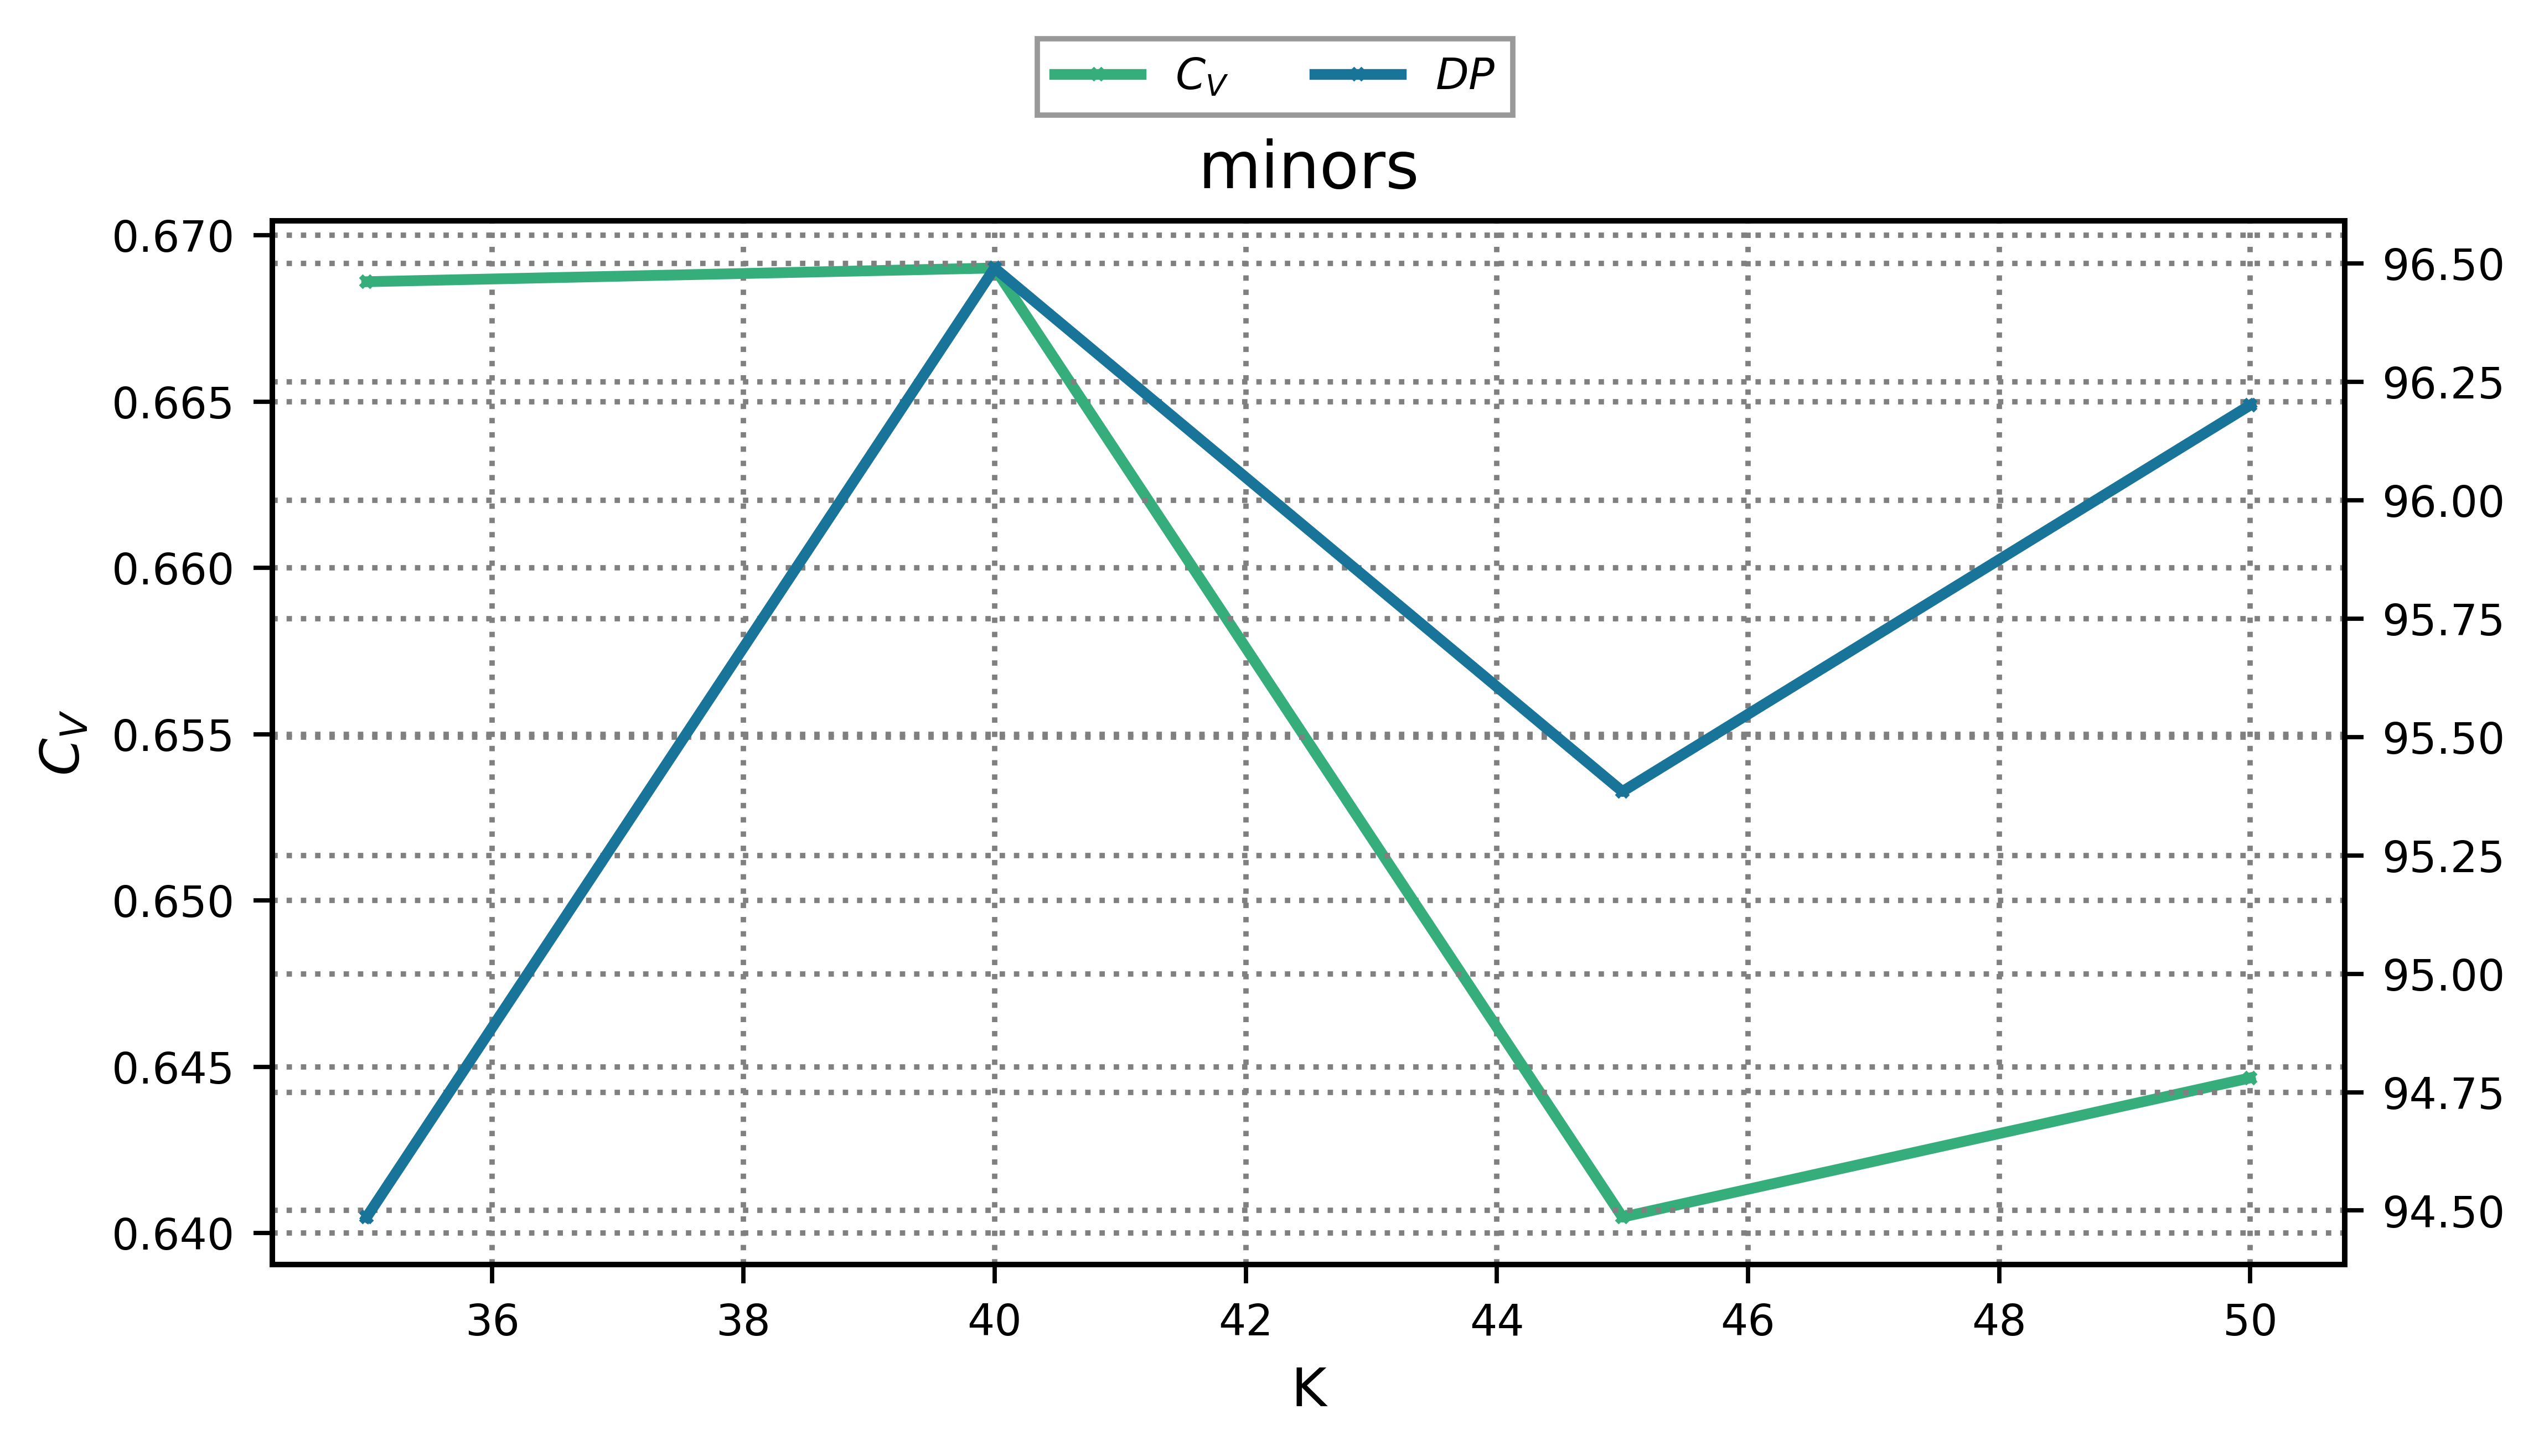

In [47]:
path_models = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet"
)

tpcs_eval = [35,40,45,50]

info_eval = {
    "ntopics": tpcs_eval,
    "cohrs_mean": [],
    #"cohrs_var" : [],
    "disp_perc_mean": [],
    #"disp_perc_var": []
}

dfs_results = []
for model_ in ["minors"]:
    info_eval = {
        "ntopics": tpcs_eval,
        "cohrs_mean": [],
        #"cohrs_var" : [],
        "disp_perc_mean": [],
        #"disp_perc_var": []
    }
    
    for tpc in tpcs_eval:
        path_model = path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / "model_data" / "TMmodel"

        cohrs = np.load(path_model.joinpath('topic_coherence.npy'))
        if any(np.isnan(cohrs)):
            with (path_model / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
                tpc_descriptions =  [el.strip() for el in fin.readlines()]

            corpusFile =  path_models / f"es_Mallet_{model_}_{tpc}_topics_FINAL" / 'train_data/corpus.txt'
            with corpusFile.open("r", encoding="utf-8") as f:
                lines = f.readlines()  # Read all lines into a list
                f.seek(0)  # Reset the file pointer to the beginning
                try:
                    corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]
                except:
                    corpus = [line.rsplit("\t0\t")[1].strip().split() for line in lines]
            dictionary = Dictionary(corpus)
            cm = CoherenceModel(topics=tpc_descriptions,texts=corpus, dictionary=dictionary,coherence="c_v", topn=15)
            cohrs = cm.get_coherence_per_topic()
        info_eval["cohrs_mean"].append(np.mean(cohrs))
        #info_eval["cohrs_var"].append(np.std(topic_coherence))
        thetas = sparse.load_npz(path_model.joinpath('thetas.npz'))
        disp_perc = 100 * ((thetas.shape[0] * thetas.shape[1]) - len(thetas.data)) / (thetas.shape[0] * thetas.shape[1])
        info_eval["disp_perc_mean"].append(np.mean(disp_perc))
        #info_eval["disp_perc_var"].append(np.std(disp_perc))

    info_eval_df = pd.DataFrame(info_eval)
    print(info_eval_df)
    dfs_results.append(info_eval_df)

models_names = ["minors"]
for info_eval_df, name in zip(dfs_results,models_names):
    
    print(f"MODELS: {name}")
    
    fig, axs = plt.subplots(nrows=1, ncols=1)

    axs.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['cohrs_mean'],
        #yerr=info_eval_df['cohrs_var'],
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#36AE7C',
        label='$C_{V}$')

    ax2 = axs.twinx()
    ax2.errorbar(
        info_eval_df['ntopics'],
        info_eval_df['disp_perc_mean'],
        #yerr=info_eval_df['disp_perc_var'], 
        fmt='x-',
        ecolor='black',
        capsize=2,
        color='#187498',
        label='$DP$')

    axs.grid(True)
    axs.set_xlabel('K')
    axs.set_ylabel('$C_{V}$')
    axs.set_title(name)
    ax2.grid(True)

    handles_all, labels_all = axs.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03),
               frameon=True, shadow=False)

## ALL

In [1]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/es_Mallet_all_55_topics_FINAL")
with (path_model / "model_data/TMmodel" / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
    topics_keys = [el.strip() for el in fin.readlines()]
topics_keys[50:55]

NameError: name 'pathlib' is not defined

In [44]:
topics_labels = [
  "Construcción y Mantenimiento de Edificios",
  "Gestión Catastral y Sostenibilidad",
  "Infraestructura y Mantenimiento de Carreteras",
  "Gestión de TI y Actualización de Software",
  "Eventos Culturales y Festividades",
  "Servicios Sociales y Eventos Comunitarios",
  "Salud y Servicios Médicos",
  "Climatización y Energía Renovable",
  "Herramientas y Equipos de Laboratorio",
  "Educación y Desarrollo Regional",
  "Gestión de Museos y Exposiciones",
  "Tecnología y Equipamiento de Telecomunicaciones",
  "Publicidad y Promoción de Eventos",
  "Mantenimiento y Reparación de Vehículos",
  "Deportes y Gestión de Emergencias",
  "Gestión de Energía y Mejora de la Eficiencia",
  "Gestión de Viajes y Eventos",
  "Suministros de Oficina y Publicidad",
  "Gestión de Aguas y Residuos",
  "Seguridad y Prevención de Incendios en Transporte Ferroviario",
  "Artes Escénicas y Gestión de Teatros",
  "Investigación y Servicios Médicos",
  "Cuidado y Asistencia a Personas Mayores",
  "Protección de Datos y Cambio Climático",
  "Gestión de Propiedades y Aprovechamientos Forestales",
  "Suministro de Electricidad y Servicios de Comunicación",
  "Publicidad y Promoción de Eventos Culturales",
  "Gestión de Bibliotecas y Apoyo Marítimo",
  "Gestión de Residuos y Reciclaje",
  "Cuidado de Espacios Verdes y Gestión de Residuos",
  "Laboratorio y Deportes Regionales",
  "Formación y Empleo para Desempleados",
  "Modernización de Infraestructuras y Seguridad",
  "Prevención de Riesgos Laborales y Propiedad Industrial",
  "Salud y Servicios Sociales",
  "Cultura, Turismo y Agricultura",
  "Salud y Suministros Farmacéuticos",
  "Salud y Servicios Sanitarios",
  "Mantenimiento y Suministros Eléctricos",
  "Gestión y Auditoría de Servicios Públicos",
  "Comunicación y Promoción de Eventos",
  "Arqueología y Obras Públicas",
  "Control de Plagas y Servicios de Traducción",
  "Promoción Comercial y Seguros",
  "Asesoramiento Jurídico y Servicios Postales",
  "Inspección de Instalaciones y Cultura",
  "Salud y Suministros Médicos",
  "Educación, Salud Animal y Cultura",
  "Turismo, Vivienda y Servicios Sociales",
  "Patentes, Deportes y Mantenimiento de Carreteras",
  "Gestión de Mobiliario de Oficina y Becas",
  "Investigación Científica y Oportunidades de Empleo",
  "Servicios Farmacéuticos y Logística",
  "Servicios de Salud Pública y Gestión de Residuos",
  "Transporte Médico y Suministros de Fontanería"
]

file_save =  (path_model / "model_data/TMmodel" / "tpc_labels.txt")
with open(file_save, 'w') as file:
    for item in topics_labels:
        file.write(item + '\n')

In [77]:
ndocs = np.load(path_model.joinpath('model_data/TMmodel/ndocs_active.npy'))
alphas = np.load(path_model.joinpath('model_data/TMmodel/alphas.npy'))*100
#for doc in alphas:
#    print(str(round(doc, 2))+"%\n")

## OUTSIDERS

In [78]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/es_Mallet_outsiders_30_topics_FINAL")
with (path_model / "model_data/TMmodel" / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
    topics_keys = [el.strip() for el in fin.readlines()]
topics_keys[20:30]

['personas_mayores, participación_activa, homologación_auditoría, instrumental_contr, ahorro_eficiencia, online, autorización, auditoría_energético, caserío, energético_alumbrado, tipología_ubicado, uoc, regulador, podología, correctivo_evolutivo',
 'unitario_inventariable, sucesivo_precio, papel_consellería, anticipado_gasto, consellería_infraestructuras, expediente_sxt, ciclo_formativo, dependiente_consejería, fibra_virgen, fibra_reciclado, prevención_riesgos, sierra_nevada, laboral, flota_autobús, antzokia',
 'área_sanitario, mariña_monforte, urgente_pequeño, lemos_construcción, lemos_transportes, barbanza, huac_laboratorio, muestra_hvx, zendal, microbiología, emergencias_isabel, utensilio, barco_valdeorras, lakua, gobierno_vasco',
 'gallego_salud, feder_respuesta, eje_operativo, pandemia, sucesivo, susceptible_financiación, feder_galicia, regulación_armonizado, gestión_integrada, abierto_sujeto, único_empresario, inversión, ue_pandemia, upv_ehu, cofinanciación',
 'isabel_zendal, te

In [53]:
topics_labels = [
  "Diagnóstico y Radiología Hospitalaria",
  "Gestión de Emergencias y Pandemias",
  "Telecomunicaciones y Recursos Humanos",
  "Gestión Hospitalaria y Cirugía",
  "Transporte Ferroviario y Producción",
  "Gestión de Aguas y Medio Ambiente",
  "Arquitectura y Urbanización para Discapacitados",
  "Farmacia y Energía Renovable",
  "Energía Fotovoltaica y Salud Mental",
  "Intervención Social y Protección a la Mujer",
  "Logística y Distribución de Medicamentos",
  "Energía Fotovoltaica y Educación",
  "Detección y Análisis de Coronavirus",
  "Educación y Atención a la Discapacidad Auditiva",
  "Transporte y Publicidad",
  "Equipamiento Médico y Gestión de Itinerarios Peatonales",
  "Prevención de Incendios y Identificación de Virus",
  "Investigación Biomédica y Detección de Virus",
  "Gestión de Residuos y Publicaciones",
  "Publicaciones y Educación",
  "Auditoría Energética y Gestión de Eficiencia",
  "Infraestructura y Prevención de Riesgos",
  "Servicios de Salud y Emergencias",
  "Respuesta a Pandemias y Gestión de Inversiones",
  "Enfermería de Emergencia y Gestión de Inundaciones",
  "Suministros Médicos y Medicina Regenerativa",
  "Salud Pública y Gestión de Saneamiento",
  "Servicios Agrícolas y Vacunación",
  "Saneamiento y Servicios de Pruebas Rápidas",
  "Desarrollo Regional y Optimización de Eficiencia"
]

file_save =  (path_model / "model_data/TMmodel" / "tpc_labels.txt")
with open(file_save, 'w') as file:
    for item in topics_labels:
        file.write(item + '\n')

In [54]:
for label in topics_keys:
    print(label+"\n")

hospital_universitario_gregorio_marañón, universitario_ramón, tomografía_axial, diagnóstico_imagen, osi, ecógrafo, catéter, tomografía_axial_computarizada, príncipe, radiología, radiodiagnóstico, complejo_hospitalario, virgen_arrixaca, plataforma_logística, bloque_quirúrgico

gasto_derivado, emergencia_ocasionado, pandemia, emergencia_adopción, intervención_subsidiario, inventario_patrimonio, virus, financiar_fondo, detección, vallado_solar, senda_trecho, trecho, demolición_infravivienda, cuerpo_bomberos, ocasión

expediente_preparado, radio_televisión, canal_sur, evolución, gallegas_retegal, redes_telecomunicación, radio_television, diputación_foral, preparado_electrónico, hardware, microsoft, recursos_humanos, sap, telefonía_móvil, cloud

empresarial_sanitaria, bloque_quirúrgico, hospital_poniente, alta_resolución, guadalquivir, costa_sol, ezkerraldea_enkarterri, sanitaria_integrada, plataforma_logística, cirugía, hospitales, oftalmología, osi, desechabl, pabellón_ifema

ets, euskotr

In [ ]:
ndocs = np.load(path_model.joinpath('model_data/TMmodel/ndocs_active.npy'))
alphas = np.load(path_model.joinpath('model_data/TMmodel/alphas.npy'))*100
#for doc in alphas:
#    #print(str(doc)+"\n")
#    print(str(round(doc, 2))+"%\n")

## INSIDERS

In [86]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/es_Mallet_insiders_12_topics_FINAL")
with (path_model / "model_data/TMmodel" / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
    topics_keys = [el.strip() for el in fin.readlines()]
topics_keys[:12]

['plurirregional_españa, fondo_feder, estrategia_desarrollo, cofinanciación, energía_fotovoltaica, desarrollo_regional, arquitectura, carril_bici, autoconsumo, favorecer_paso, casco_urbano, ultramarino, subvención_singular, consejería_familia, túnel',
 'prevención_ajeno, prevención_riesgos, ayuda_domicilio, laboral, higiene_industrial, autónoma_islas, industrial_ergonomía, administración_comunidad, asesoramiento_jurídico, prescripciones_técnicas, protección_datos, riesgo_laboral, baleares, especialidad_higiene, conciliación_vida',
 'csic, consejo_superior, investigaciones_cientificas, microsoft, subdirección_general, direccion_general, hardware, oracle, festival_internacional, evolución, cloud, ministerio_defensa, división_económica, técnica_mº, representación_artístico',
 'empleo_agrario, programa_fomento, concesión_explotación, máquina_expendedor, cooperación_internacional, común_especial, agencia_española, dominio_explotación, privativo, explotación_barra, iluminación_sonido, fotoco

In [90]:
topics_labels = [
  "Desarrollo Regional y Energía Fotovoltaica",
  "Prevención de Riesgos Laborales y Protección de Datos",
  "Investigación Científica y Tecnología de la Información",
  "Empleo Agrario y Cooperación Internacional",
  "Turismo y Transporte Marítimo",
  "Servicios Postales y Turismo",
  "Gestión de Residuos y Catastro Inmobiliario",
  "Investigación Científica y Salud Pública",
  "Servicios Sanitarios y Medicamentos",
  "Instituciones Penitenciarias y Seguros",
  "Salud Ambulatoria y Prevención de Incendios",
  "Gestión Forestal y Catastro"
]

file_save =  (path_model / "model_data/TMmodel" / "tpc_labels.txt")
with open(file_save, 'w') as file:
    for item in topics_labels:
        file.write(item + '\n')

In [92]:
for label in topics_keys:
    print(label+"\n")

plurirregional_españa, fondo_feder, estrategia_desarrollo, cofinanciación, energía_fotovoltaica, desarrollo_regional, arquitectura, carril_bici, autoconsumo, favorecer_paso, casco_urbano, ultramarino, subvención_singular, consejería_familia, túnel

prevención_ajeno, prevención_riesgos, ayuda_domicilio, laboral, higiene_industrial, autónoma_islas, industrial_ergonomía, administración_comunidad, asesoramiento_jurídico, prescripciones_técnicas, protección_datos, riesgo_laboral, baleares, especialidad_higiene, conciliación_vida

csic, consejo_superior, investigaciones_cientificas, microsoft, subdirección_general, direccion_general, hardware, oracle, festival_internacional, evolución, cloud, ministerio_defensa, división_económica, técnica_mº, representación_artístico

empleo_agrario, programa_fomento, concesión_explotación, máquina_expendedor, cooperación_internacional, común_especial, agencia_española, dominio_explotación, privativo, explotación_barra, iluminación_sonido, fotocopiadora, pl

In [95]:
ndocs = np.load(path_model.joinpath('model_data/TMmodel/ndocs_active.npy'))
alphas = np.load(path_model.joinpath('model_data/TMmodel/alphas.npy'))*100
for doc in alphas:
    #print(str(doc)+"\n")
    print(str(round(doc, 2))+"%\n")

13.23%

11.86%

10.41%

10.17%

8.82%

7.9%

7.16%

6.91%

6.77%

6.35%

5.7%

4.73%



## MINORS

In [100]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/es_Mallet_minors_40_topics_FINAL")
with (path_model / "model_data/TMmodel" / "tpc_descriptions.txt").open('r', encoding='utf8') as fin:
    topics_keys = [el.strip() for el in fin.readlines()]
topics_keys[20:40]

['sabores_quijote, ambulatorio, productos_platos, evento_gastronómico, actividad_convenios, quirófano, tomografía_axial, tomografía_axial_computarizada, plato_tierra, cirugía, bloque_quirúrgico, oftalmología, prevención_violencia, universitario_espases, maz',
 'memoria, fungible_laboratorio, reactivo_químico, guante_nitrilo, pipeta, punta_filtro, punta, reactivo_quimico, cultivo, material_fungible, justificativa_control, reacción_cadena, molecular, punta_pipeta, placa_petri',
 'carpintería_albañilería, fontanería, cerrajería, consumible, electricidad, bombilla, cerrajería_electricidad, bombilla_jardinería, reacción_cadena, polimerasa, signo, reacción_cadena_polimerasa, ácido_desoxirribonucleico, secuenciación, central_veterinaria',
 'escolar_ruta, uniformidad, chaleco, selectivo, funda, agente_policía, periodo_comprendido, pantalón, uniforme, escudo, logotipo, cuerpo_policía, provincia_patrocinar, policial, spot_promocional',
 'comunicación_promoción, consejería_hacienda, presupuestos_

In [101]:
topics_labels = [
  "Reparación y Mantenimiento de Edificios",
  "Prevención y Concienciación sobre Violencia de Género",
  "Promoción y Celebración de Eventos Festivos",
  "Gestión de Datos y Contabilidad",
  "Organización de Eventos y Viajes",
  "Mantenimiento y Mejora de Espacios Urbanos",
  "Equipamiento y Mobiliario para Voluntarios",
  "Suministros de Ferretería",
  "Estudios Topográficos y Medioambientales",
  "Organización y Promoción de Eventos Culturales",
  "Gestión y Mantenimiento de Redes de Telecomunicaciones",
  "Preservación y Promoción del Patrimonio Cultural",
  "Energía Renovable y Construcción Sostenible",
  "Salud Pública y Mantenimiento de Infraestructuras",
  "Mantenimiento y Suministros para Vehículos de Emergencia",
  "Investigación y Desarrollo en Agricultura y Energía",
  "Organización y Promoción de Eventos Deportivos",
  "Publicidad y Promoción Institucional",
  "Suministros de Oficina y Tecnología",
  "Publicidad y Promoción de Productos Regionales",
  "Eventos Gastronómicos y Servicios Médicos",
  "Equipamiento y Reactivos de Laboratorio",
  "Servicios de Mantenimiento y Biología Molecular",
  "Equipamiento Policial y Promoción",
  "Gestión de Energía y Servicios Públicos",
  "Educación Profesional y Promoción Turística",
  "Servicios de Bienestar y Equipamiento Deportivo",
  "Adquisiciones y Diseño de Eventos",
  "Servicios Médicos y Suministros de Higiene",
  "Alimentación y Educación para Ancianos",
  "Educación y Traducción de Investigaciones",
  "Prevención de Riesgos y Gestión de Residuos",
  "Acondicionamiento y Servicios para la Familia",
  "Viajes y Programación Cultural",
  "Publicidad y Suministros de Laboratorio",
  "Bienestar Social y Deportes",
  "Climatización y Suministros de Oficina",
  "Salud y Patentes Médicas",
  "Asesoramiento Jurídico y Educación",
  "Suministros Industriales y Consumo"
]

file_save =  (path_model / "model_data/TMmodel" / "tpc_labels.txt")
with open(file_save, 'w') as file:
    for item in topics_labels:
        file.write(item + '\n')

In [102]:
for label in topics_labels:
    print(label+"\n")

Reparación y Mantenimiento de Edificios

Prevención y Concienciación sobre Violencia de Género

Promoción y Celebración de Eventos Festivos

Gestión de Datos y Contabilidad

Organización de Eventos y Viajes

Mantenimiento y Mejora de Espacios Urbanos

Equipamiento y Mobiliario para Voluntarios

Suministros de Ferretería

Estudios Topográficos y Medioambientales

Organización y Promoción de Eventos Culturales

Gestión y Mantenimiento de Redes de Telecomunicaciones

Preservación y Promoción del Patrimonio Cultural

Energía Renovable y Construcción Sostenible

Salud Pública y Mantenimiento de Infraestructuras

Mantenimiento y Suministros para Vehículos de Emergencia

Investigación y Desarrollo en Agricultura y Energía

Organización y Promoción de Eventos Deportivos

Publicidad y Promoción Institucional

Suministros de Oficina y Tecnología

Publicidad y Promoción de Productos Regionales

Eventos Gastronómicos y Servicios Médicos

Equipamiento y Reactivos de Laboratorio

Servicios de Manten

In [ ]:
ndocs = np.load(path_model.joinpath('model_data/TMmodel/ndocs_active.npy'))
alphas = np.load(path_model.joinpath('model_data/TMmodel/alphas.npy'))*100
for doc in ndocs:
    print(str(doc)+"\n")
    #print(str(round(doc, 2))+"%\n")